In [4]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import math
import gc

from sklearn.metrics import roc_auc_score

import pickle
def dump_pkl(data, filename):
  with open(filename, 'wb') as handle:
    pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

def load_pkl(filename):
  with open(filename, 'rb') as handle:
    data = pickle.load(handle)
  return data

### Load data

In [8]:
df_1min = load_pkl('experiments/model_one_fc/data/data_shift_time_1min.pkl')
# df_5min = load_pkl('experiments/model_one_fc/data/data_shift_time_5min.pkl')
# df_1hour = load_pkl('experiments/model_one_fc/data/data_shift_time_1hour.pkl')
# df_1day = load_pkl('experiments/model_one_fc/data/data_shift_time_1day.pkl')

In [13]:
mask_train = np.array((pd.Timestamp('2023-10-01') <= df_1min['time']) & (df_1min['time'] < pd.Timestamp('2024-06-01')))
mask_valid = np.array((pd.Timestamp('2024-06-01') <= df_1min['time']) & (df_1min['time'] < pd.Timestamp('2024-08-01')))
mask_test = np.array((pd.Timestamp('2024-08-01') <= df_1min['time']) & (df_1min['time'] < pd.Timestamp('2024-10-01')))
mask_test2 = np.array((pd.Timestamp('2024-10-01') <= df_1min['time']) & (df_1min['time'] < pd.Timestamp('2024-11-19')))

In [15]:
mask_train.sum(), mask_valid.sum(), mask_test.sum(), mask_test2.sum()

(2453935, 597323, 620944, 497823)

In [17]:
mask_data = mask_train|mask_valid|mask_test|mask_test2
(mask_data).sum()

4170025

In [19]:
mask_train.sum()/(mask_data).sum(), mask_valid.sum()/(mask_data).sum(), mask_test.sum()/(mask_data).sum(), mask_test2.sum()/(mask_data).sum()

(0.5884700931049575,
 0.14324206689408336,
 0.14890654132768988,
 0.11938129867326934)

In [21]:
df_1min['target'] = (df_1min['result'] == 'WIN').astype(int)

In [22]:
df_1min.loc[mask_train, 'target'].mean(), df_1min.loc[mask_valid, 'target'].mean(), df_1min.loc[mask_test, 'target'].mean(), df_1min.loc[mask_test2, 'target'].mean()

(0.06044455130229611,
 0.10156816328853903,
 0.11664175835502075,
 0.10381199743684)

### Callback

In [31]:
from tensorflow import keras

def lr_warmup_cosine_decay(global_step,
                           warmup_steps,
                           hold = 0,
                           total_steps=0,
                           start_lr=0.0,
                           target_lr=1e-3):
    # Cosine decay
    # There is no tf.pi so we wrap np.pi as a TF constant
    #learning_rate = 0.5 * target_lr * (1 + tf.cos(tf.constant(np.pi) * (global_step - warmup_steps - hold) / float(total_steps - warmup_steps - hold)))
    learning_rate = 0.5 * target_lr * (1 + tf.cos(tf.constant(np.pi) * tf.cast((global_step - warmup_steps - hold), tf.float32) / tf.cast(total_steps - warmup_steps - hold, tf.float32)))


    # Target LR * progress of warmup (=1 at the final warmup step)
    warmup_lr = target_lr * (global_step / warmup_steps)

    # Choose between `warmup_lr`, `target_lr` and `learning_rate` based on whether `global_step < warmup_steps` and we're still holding.
    # i.e. warm up if we're still warming up and use cosine decayed lr otherwise
    if hold > 0:
        learning_rate = tf.where(global_step > warmup_steps + hold,
                                 learning_rate, target_lr)

    learning_rate = tf.where(global_step < warmup_steps, warmup_lr, learning_rate)

    return learning_rate


class WarmUpCosineDecay(keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, start_lr, target_lr, warmup_steps, total_steps, hold):
        super().__init__()
        self.start_lr = start_lr
        self.target_lr = target_lr
        self.warmup_steps = warmup_steps
        self.total_steps = total_steps
        self.hold = hold

    def __call__(self, step):
        lr = lr_warmup_cosine_decay(global_step=step,
                                    total_steps=self.total_steps,
                                    warmup_steps=self.warmup_steps,
                                    start_lr=self.start_lr,
                                    target_lr=self.target_lr,
                                    hold=self.hold)

        return tf.where(
            step > self.total_steps, 0.0, lr, name="learning_rate"
        )
    def get_config(self):
        config = {
          'start_lr': self.start_lr,
          'target_lr': self.target_lr,
          'warmup_steps': self.warmup_steps,
          'total_steps': self.total_steps,
          'hold': self.hold
        }
        return config



In [33]:
# import keras

# model = keras.saving.load_model('./best_models/model_0001.keras',
#                                 custom_objects={'WarmUpCosineDecay': WarmUpCosineDecay})


# AUC_ROC:  [0.825, 0.723, 0.746, 0.737]
# PRECISION:  [0.402, 0.331, 0.354, 0.412]

# Evaluate

In [43]:
df = df_1min.copy()
df.head()

,time,open,close,volume,low,high,ticker,index_1min_start,index_5min,index_start_5min,index_1hour,index_start_1hour,index_1day,index_start_1day,result,delta_time,target
0,2022-10-03 10:01:00,219.00,219.93,87793.0,218.00,220.25,GAZP,0,NaN,NaN,NaN,NaN,NaN,NaN,LOSE,0 days 00:04:00,0
1,2022-10-03 10:02:00,219.80,220.80,61549.0,219.70,220.55,GAZP,0,NaN,NaN,NaN,NaN,NaN,NaN,LOSE,0 days 00:01:00,0
2,2022-10-03 10:03:00,220.24,219.34,52640.0,219.20,220.38,GAZP,0,NaN,NaN,NaN,NaN,NaN,NaN,LOSE,0 days 00:03:00,0
3,2022-10-03 10:04:00,219.17,218.96,61506.0,217.70,219.40,GAZP,0,NaN,NaN,NaN,NaN,NaN,NaN,LOSE,0 days 00:02:00,0
4,2022-10-03 10:05:00,218.82,218.30,51464.0,217.76,218.96,GAZP,0,0.0,0,NaN,NaN,NaN,NaN,LOSE,0 days 00:07:00,0


In [45]:
df['sample'] = None
df.loc[mask_valid, 'sample'] = 'valid'
df.loc[mask_test, 'sample'] = 'test'
df.loc[mask_test2, 'sample'] = 'test2'

### load data

In [49]:
#load data

y_pred_valid = load_pkl('./best_models/model_0001/y_pred_valid.pkl')
y_pred_test = load_pkl('./best_models/model_0001/y_pred_test.pkl')
y_pred_test2 = load_pkl('./best_models/model_0001/y_pred_test2.pkl')


df['y_pred'] = None
df.loc[mask_valid, 'y_pred'] = y_pred_valid
df.loc[mask_test, 'y_pred'] = y_pred_test
df.loc[mask_test2, 'y_pred'] = y_pred_test2

In [51]:
# AUC_ROC:  [0.825, 0.723, 0.746, 0.737]
# PRECISION:  [0.402, 0.331, 0.354, 0.412]

### auc_roc

In [54]:
roc_auc_score(df.loc[mask_valid, 'target'], df.loc[mask_valid, 'y_pred']), roc_auc_score(df.loc[mask_test, 'target'], df.loc[mask_test, 'y_pred']), roc_auc_score(df.loc[mask_test2, 'target'], df.loc[mask_test2, 'y_pred'])

(0.7224182021118397, 0.7436059076927718, 0.7392876420389833)

### target4

In [58]:
threshold = np.quantile(df.loc[mask_valid, 'y_pred'], q=0.99)
mask = df['y_pred'] > threshold
print(df.loc[mask_valid&mask, 'target'].mean())

threshold = np.quantile(df.loc[mask_test, 'y_pred'], q=0.99)
mask = df['y_pred'] > threshold
print(df.loc[mask_test&mask, 'target'].mean())

threshold = np.quantile(df.loc[mask_test2, 'y_pred'], q=0.99)
mask = df['y_pred'] > threshold
print(df.loc[mask_test2&mask, 'target'].mean())

0.3289253431536659
0.35893719806763286
0.418758786905001


### Посомтрим на вероятности

In [62]:
inds = np.random.choice(df.index[mask_valid|mask_test|mask_test2], size=20)
inds

array([7755649,  851860, 1319145,  814084, 2211536, 7799017, 7782445,
       3882563, 1716522, 1332365, 5641199, 4769636, 6502241, 2616930,
       2564124, 3850774, 7313788, 1709310, 7406723, 4328019])

7755649
90


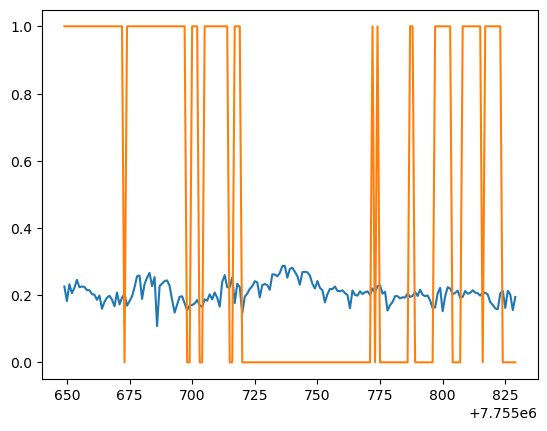

851860
0


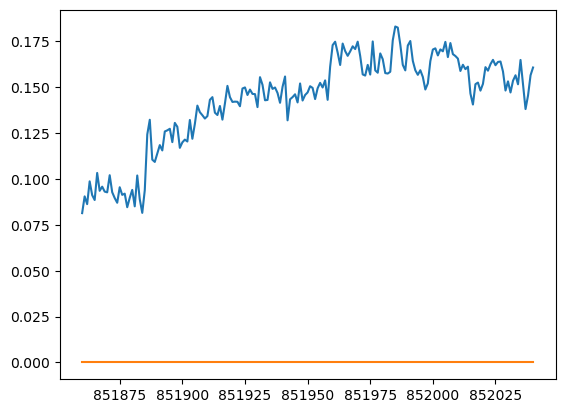

1319145
0


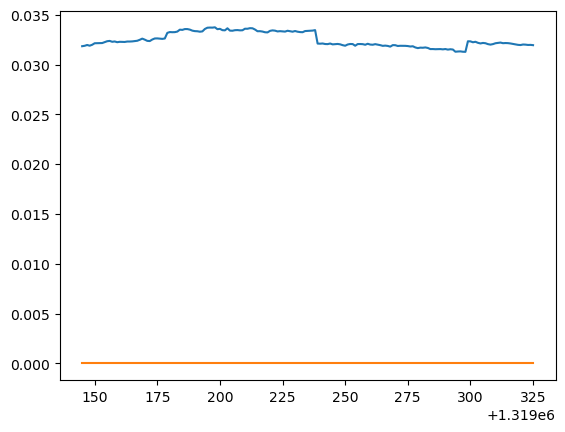

814084
0


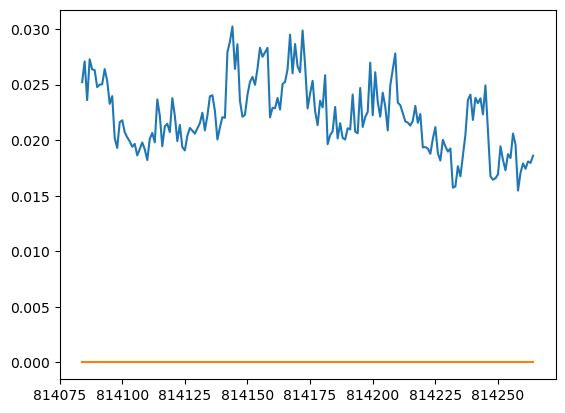

2211536
11


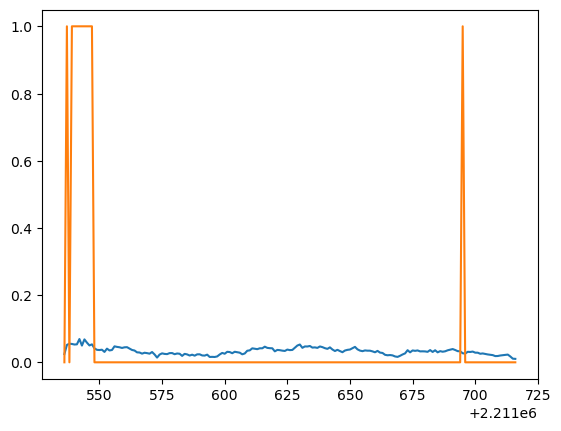

7799017
0


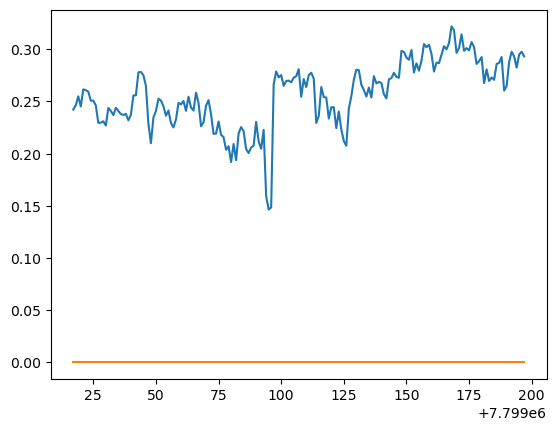

7782445
116


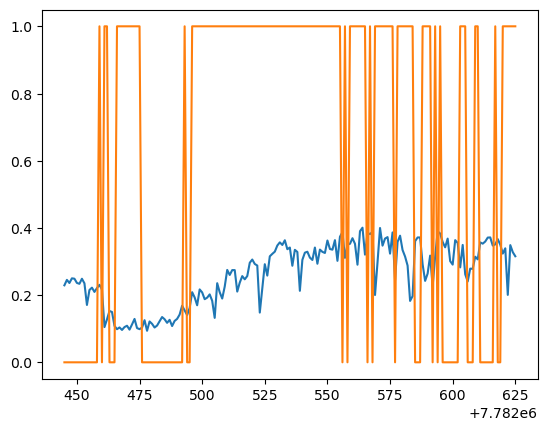

3882563
0


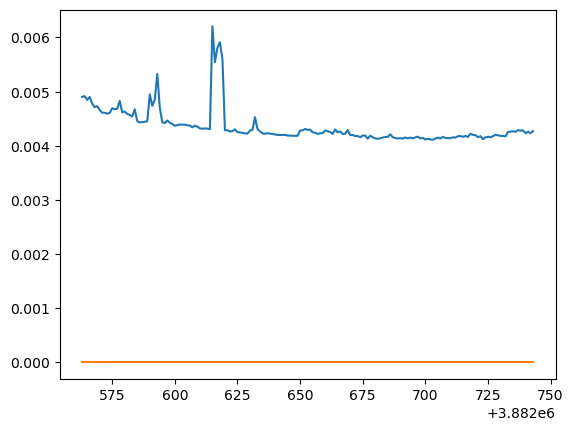

1716522
0


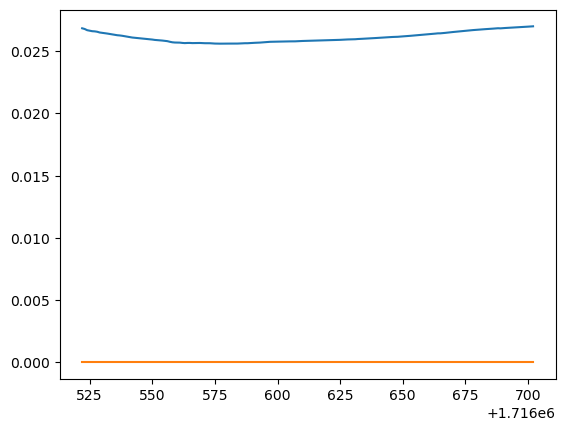

1332365
0


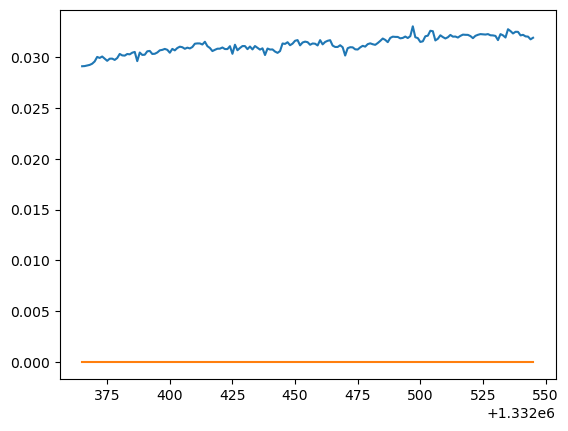

5641199
0


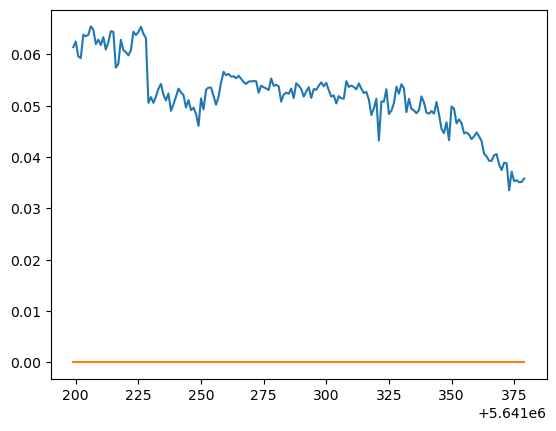

4769636
0


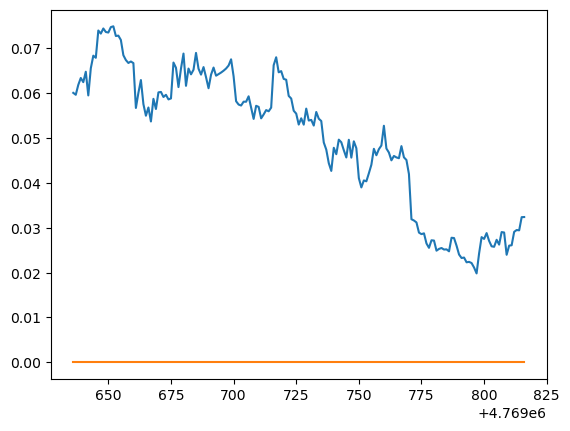

6502241
81


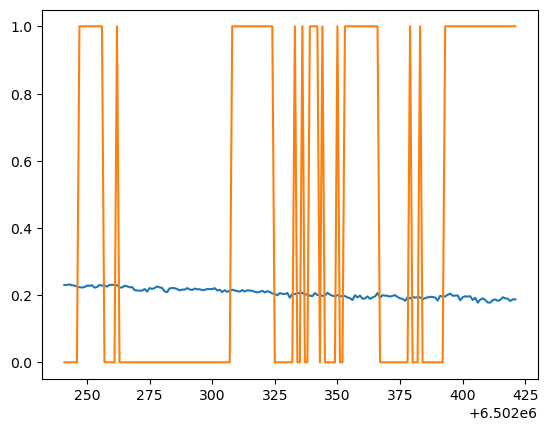

2616930
18


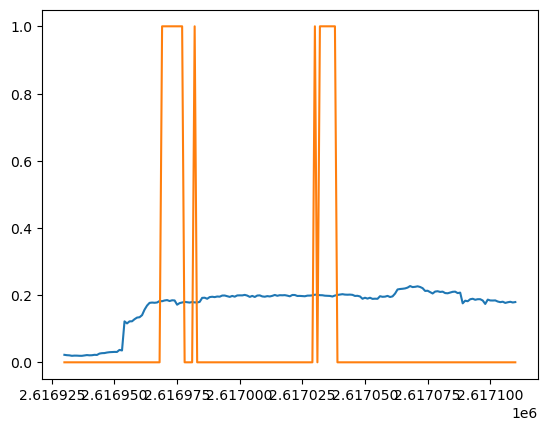

2564124
0


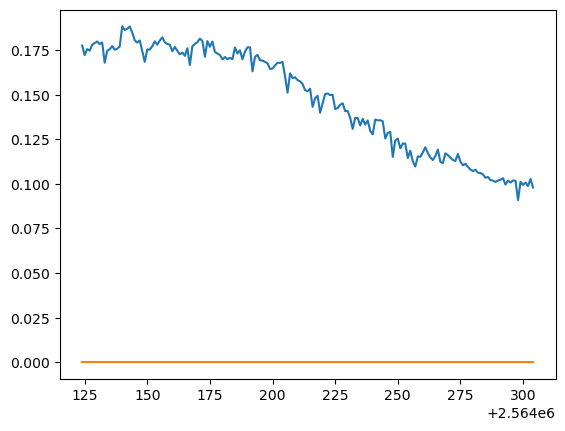

3850774
0


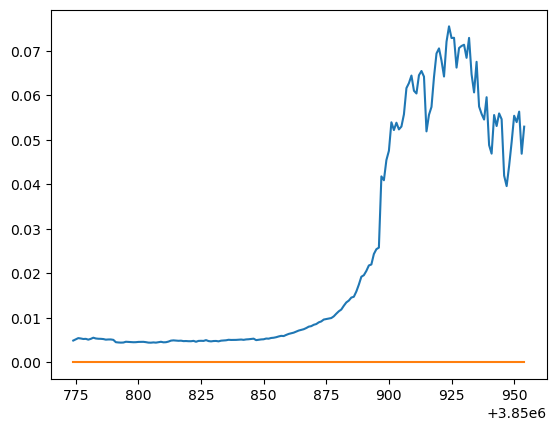

7313788
0


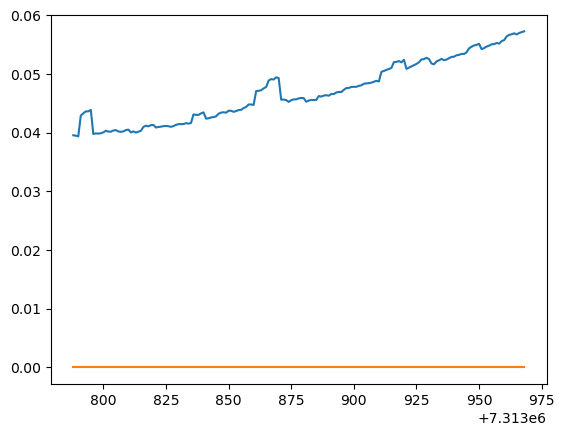

1709310
0


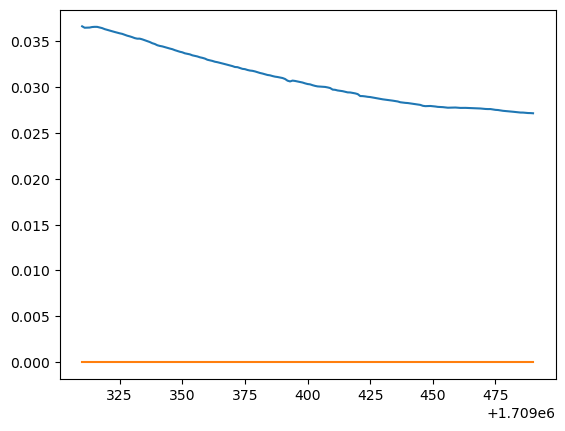

7406723
134


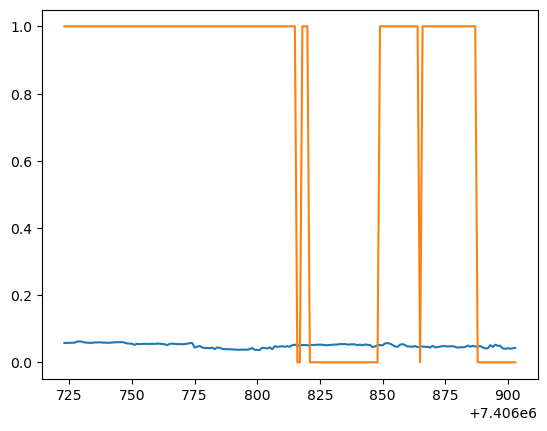

4328019
0


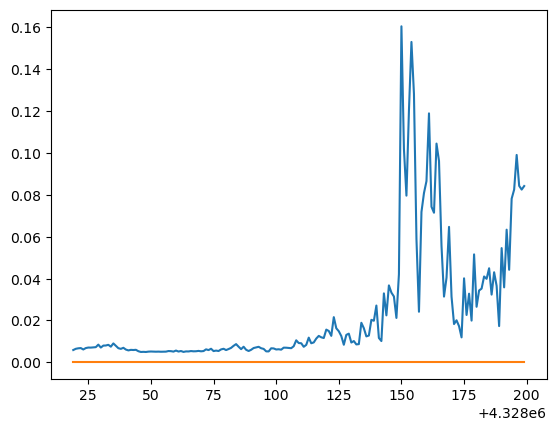

In [64]:
window = 180#неделя
for i in inds:
    print(i)
    print(df.loc[i:i+window, 'target'].sum())
    plt.plot(df.loc[i:i+window, 'y_pred'])
    plt.plot(df.loc[i:i+window, 'target'])
    plt.show()

### target24

In [72]:
df

,time,open,close,volume,low,high,ticker,index_1min_start,index_5min,index_start_5min,index_1hour,index_start_1hour,index_1day,index_start_1day,result,delta_time,target,sample,y_pred
0,2022-10-03 10:01:00,219.000,219.930,87793.0,218.000,220.250,GAZP,0,NaN,NaN,NaN,NaN,NaN,NaN,LOSE,0 days 00:04:00,0,None,None
1,2022-10-03 10:02:00,219.800,220.800,61549.0,219.700,220.550,GAZP,0,NaN,NaN,NaN,NaN,NaN,NaN,LOSE,0 days 00:01:00,0,None,None
2,2022-10-03 10:03:00,220.240,219.340,52640.0,219.200,220.380,GAZP,0,NaN,NaN,NaN,NaN,NaN,NaN,LOSE,0 days 00:03:00,0,None,None
3,2022-10-03 10:04:00,219.170,218.960,61506.0,217.700,219.400,GAZP,0,NaN,NaN,NaN,NaN,NaN,NaN,LOSE,0 days 00:02:00,0,None,None
4,2022-10-03 10:05:00,218.820,218.300,51464.0,217.760,218.960,GAZP,0,0.0,0,NaN,NaN,NaN,NaN,LOSE,0 days 00:07:00,0,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7847341,2024-11-19 23:46:00,38.485,38.455,1020.0,38.455,38.490,RUAL,7410480,1607833.0,1517952,138245.0,130521,9722.0,9181,DNF,100 days 00:00:00,0,None,None
7847342,2024-11-19 23:47:00,38.490,38.510,1102.0,38.490,38.510,RUAL,7410480,1607833.0,1517952,138245.0,130521,9722.0,9181,DNF,100 days 00:00:00,0,None,None
7847343,2024-11-19 23:48:00,38.500,38.520,665.0,38.475,38.520,RUAL,7410480,1607833.0,1517952,138245.0,130521,9722.0,9181,DNF,100 days 00:00:00,0,None,None
7847344,2024-11-19 23:49:00,38.520,38.520,781.0,38.520,38.530,RUAL,7410480,1607833.0,1517952,138245.0,130521,9722.0,9181,DNF,100 days 00:00:00,0,None,None


In [74]:
df['result'].value_counts(normalize=True)

result
DNF     0.610235
LOSE    0.307435
WIN     0.082329
Name: proportion, dtype: float64

In [76]:
df_result = load_pkl('./experiments/model_one_fc/df_result_wait_1day.pkl')
df_result

,ind,time,close,result,ticker,delta_time
0,0,2022-10-03 10:00:00,219.930,LOSE,GAZP,0 days 00:04:00
1,1,2022-10-03 10:01:00,220.800,LOSE,GAZP,0 days 00:01:00
2,2,2022-10-03 10:02:00,219.340,LOSE,GAZP,0 days 00:03:00
3,3,2022-10-03 10:03:00,218.960,LOSE,GAZP,0 days 00:02:00
4,4,2022-10-03 10:04:00,218.300,LOSE,GAZP,0 days 00:07:00
...,...,...,...,...,...,...
7847341,7847341,2024-11-19 23:45:00,38.455,DNF,RUAL,-1
7847342,7847342,2024-11-19 23:46:00,38.510,DNF,RUAL,-1
7847343,7847343,2024-11-19 23:47:00,38.520,DNF,RUAL,-1
7847344,7847344,2024-11-19 23:48:00,38.520,DNF,RUAL,-1


In [77]:
df_result['delta_time'] = df_result['delta_time'].replace(-1, pd.Timedelta('100 days'))
mask = df_result['delta_time'] > pd.Timedelta('24 hours')
df_result.loc[mask, 'result'] = 'DNF'

/var/folders/rm/zt5_90s5727289mv2gzbkw980000gn/T/ipykernel_89124/3761136502.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_result['delta_time'] = df_result['delta_time'].replace(-1, pd.Timedelta('100 days'))


In [78]:
df_result['result'].value_counts(normalize=True)

result
LOSE    0.566594
DNF     0.235417
WIN     0.197989
Name: proportion, dtype: float64

In [79]:
df['target24'] = (df_result['result'] == 'WIN').astype(int)

In [81]:
threshold = np.quantile(df.loc[mask_valid, 'y_pred'], q=0.99)
mask = df['y_pred'] > threshold
print(df.loc[mask_valid&mask, 'target24'].mean())

threshold = np.quantile(df.loc[mask_test, 'y_pred'], q=0.99)
mask = df['y_pred'] > threshold
print(df.loc[mask_test&mask, 'target24'].mean())

threshold = np.quantile(df.loc[mask_test2, 'y_pred'], q=0.99)
mask = df['y_pred'] > threshold
print(df.loc[mask_test2&mask, 'target24'].mean())

0.4057582859055909
0.41578099838969407
0.43462542679252864


### Распределение вероятностей в целом

In [85]:
import warnings
warnings.filterwarnings('ignore')


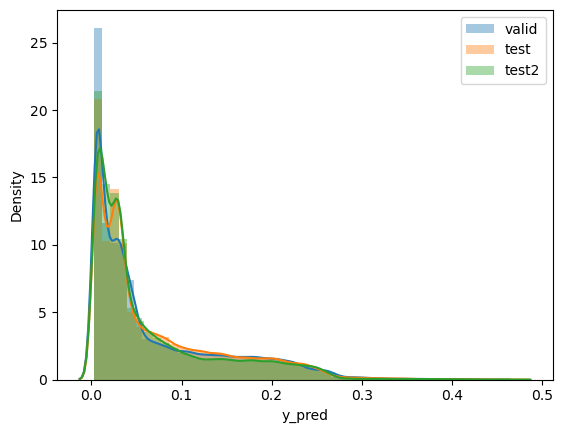

In [86]:

sns.distplot(df.loc[mask_valid, 'y_pred'], label='valid')
sns.distplot(df.loc[mask_test, 'y_pred'], label='test')
sns.distplot(df.loc[mask_test2, 'y_pred'], label='test2')
plt.legend()

In [87]:
#не так уж и плохо, есть надежды

### Распределение успеха (target4) по бинам

[0.2582 0.2793]


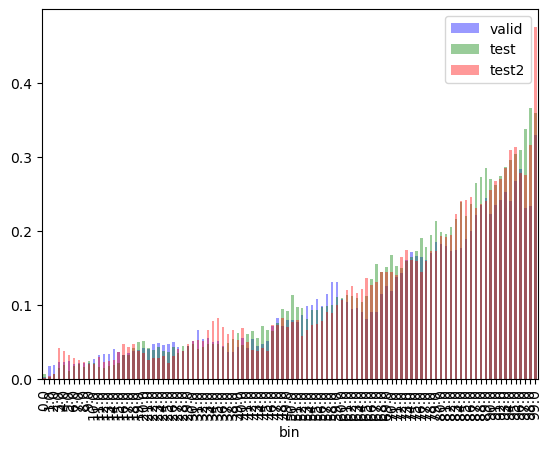

In [403]:
col_target = 'target'
q_count = 100

print(np.round(np.quantile(df.loc[mask_valid, 'y_pred'], q=[0.98, 0.99]).astype(float), decimals=4))

df['bin'] = None

df.loc[mask_valid, 'bin'] = pd.qcut(df.loc[mask_valid, 'y_pred'], q_count, labels=False)
q = pd.qcut(df.loc[mask_valid, 'y_pred'], q_count, retbins=True)[1]
df.loc[mask_valid, ['bin', col_target]].groupby('bin')[col_target].mean().plot.bar(sharex=True, label='valid', color='blue', alpha=0.4)


df.loc[mask_test, 'bin'] = pd.cut(df.loc[mask_test, 'y_pred'], bins=q, labels=False, include_lowest=True)
df.loc[mask_test, 'bin'] = df.loc[mask_test, 'bin'].fillna(q_count-1)
df.loc[mask_test, ['bin', col_target]].groupby('bin')[col_target].mean().plot.bar(sharex=True, label='test', color='green', alpha=0.4)


df.loc[mask_test2, 'bin'] = pd.cut(df.loc[mask_test2, 'y_pred'], bins=q, labels=False, include_lowest=True)
df.loc[mask_test2, 'bin'] = df.loc[mask_test2, 'bin'].fillna(q_count-1)
df.loc[mask_test2, ['bin', col_target]].groupby('bin')[col_target].mean().plot.bar(sharex=True,label='test2', color='red', alpha=0.4)

plt.legend()
plt.show()

### Распределени успеха(target24) по бинам

In [361]:
# col_target = 'target24'
# q_count = 50

# print(np.round(np.quantile(df.loc[mask_valid, 'y_pred'], q=[0.98, 0.99]).astype(float), decimals=4))

# df['bin'] = None

# df.loc[mask_valid, 'bin'] = pd.qcut(df.loc[mask_valid, 'y_pred'], q_count, labels=False)
# q = pd.qcut(df.loc[mask_valid, 'y_pred'], q_count, retbins=True)[1]
# df.loc[mask_valid, ['bin', col_target]].groupby('bin')[col_target].mean().plot.bar(sharex=True, label='valid', color='blue', alpha=0.4)


# df.loc[mask_test, 'bin'] = pd.cut(df.loc[mask_test, 'y_pred'], bins=q, labels=False, include_lowest=True)
# df.loc[mask_test, 'bin'] = df.loc[mask_test, 'bin'].fillna(q_count-1)
# df.loc[mask_test, ['bin', col_target]].groupby('bin')[col_target].mean().plot.bar(sharex=True, label='test', color='green', alpha=0.4)


# df.loc[mask_test2, 'bin'] = pd.cut(df.loc[mask_test2, 'y_pred'], bins=q, labels=False, include_lowest=True)
# df.loc[mask_test2, 'bin'] = df.loc[mask_test2, 'bin'].fillna(q_count-1)
# df.loc[mask_test2, ['bin', col_target]].groupby('bin')[col_target].mean().plot.bar(sharex=True,label='test2', color='red', alpha=0.4)

# plt.legend()
# plt.show()

In [96]:
pd.DataFrame(np.array([np.quantile(df.loc[mask_valid, 'y_pred'], q=np.arange(0.95, 1, 0.01)),
              np.quantile(df.loc[mask_test, 'y_pred'], q=np.arange(0.95, 1, 0.01)),
              np.quantile(df.loc[mask_test2, 'y_pred'], q=np.arange(0.95, 1, 0.01))
                       
                      ]).T)

,0,1,2
0,0.224441,0.2253,0.220991
1,0.232813,0.233719,0.229898
2,0.244342,0.24254,0.239357
3,0.258219,0.25389,0.249535
4,0.279289,0.282332,0.263039
5,0.44805,0.469455,0.471787


In [98]:
#Более менее кстати 

### В разрезе тикеров (внутри каждого тикера своя вероятность)

In [102]:
def distplot(df, col_target=None, q_count=None):
    for ticker in df['ticker'].unique():
        print(ticker)
        
        df_tk = df.loc[df['ticker'] == ticker].copy()

        mask_valid = df_tk['sample'] == 'valid'
        mask_test = df_tk['sample'] == 'test'
        mask_test2 = df_tk['sample'] == 'test2'

        print(np.round(np.quantile(df_tk.loc[mask_valid, 'y_pred'], q=[0.98, 0.99]).astype(float), decimals=4))
        
        sns.distplot(df_tk.loc[mask_valid, 'y_pred'], label='valid')
        sns.distplot(df_tk.loc[mask_test, 'y_pred'], label='test')
        sns.distplot(df_tk.loc[mask_test2, 'y_pred'], label='test2')
        plt.legend()
        plt.show()



        
        df_tk['bin'] = None
        
        df_tk.loc[mask_valid, 'bin'] = pd.qcut(df_tk.loc[mask_valid, 'y_pred'], q_count, labels=False)
        q = pd.qcut(df_tk.loc[mask_valid, 'y_pred'], q_count, retbins=True)[1]
        df_tk.loc[mask_valid, ['bin', col_target]].groupby('bin')[col_target].mean().plot.bar(sharex=True, label='valid', color='blue', alpha=0.4)
        
        
        df_tk.loc[mask_test, 'bin'] = pd.cut(df_tk.loc[mask_test, 'y_pred'], bins=q, labels=False, include_lowest=True)
        df_tk.loc[mask_test, 'bin'] = df_tk.loc[mask_test, 'bin'].fillna(q_count-1)
        df_tk.loc[mask_test, ['bin', col_target]].groupby('bin')[col_target].mean().plot.bar(sharex=True, label='test', color='green', alpha=0.4)
        
        
        df_tk.loc[mask_test2, 'bin'] = pd.cut(df_tk.loc[mask_test2, 'y_pred'], bins=q, labels=False, include_lowest=True)
        df_tk.loc[mask_test2, 'bin'] = df_tk.loc[mask_test2, 'bin'].fillna(q_count-1)
        df_tk.loc[mask_test2, ['bin', col_target]].groupby('bin')[col_target].mean().plot.bar(sharex=True,label='test2', color='red', alpha=0.4)
        
        plt.legend()
        plt.show()

### таргет4

In [108]:
#[0.2582 0.2793]

GAZP
[0.2449 0.257 ]


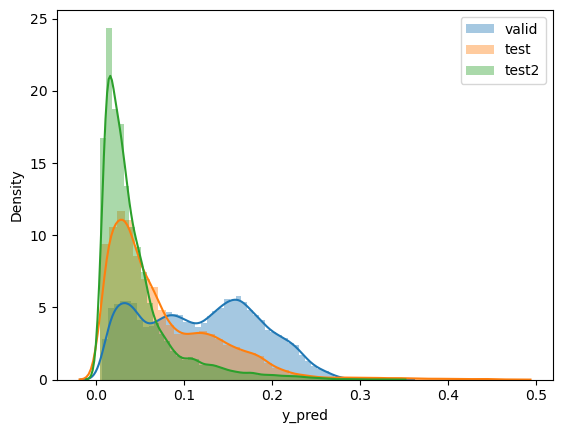

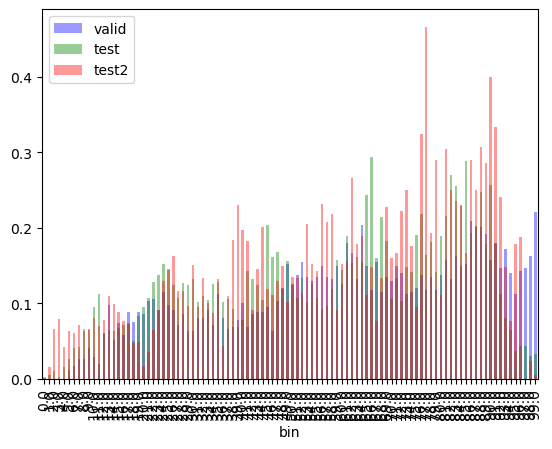

SBER
[0.1391 0.1688]


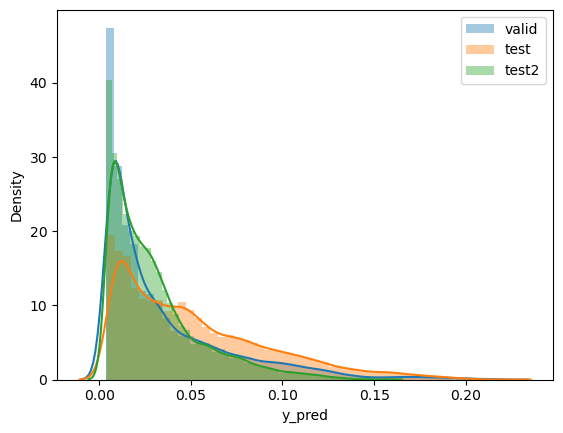

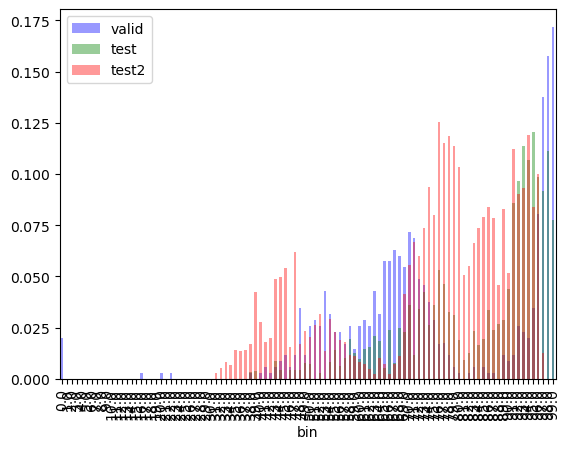

LKOH
[0.049  0.0523]


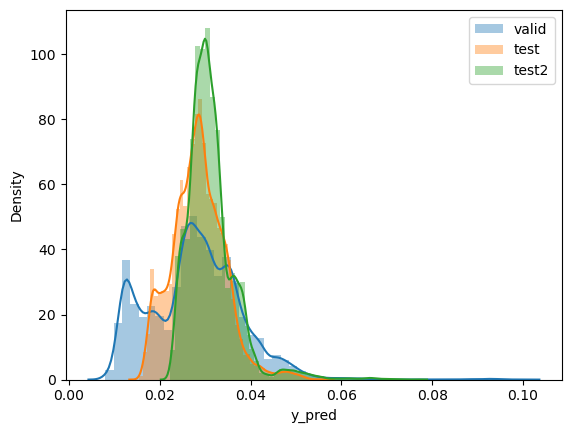

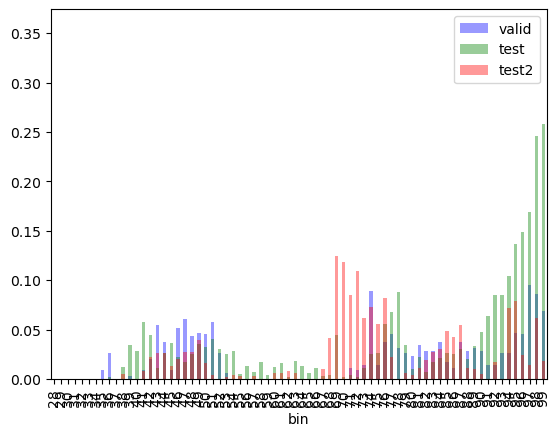

MGNT
[0.0541 0.0665]


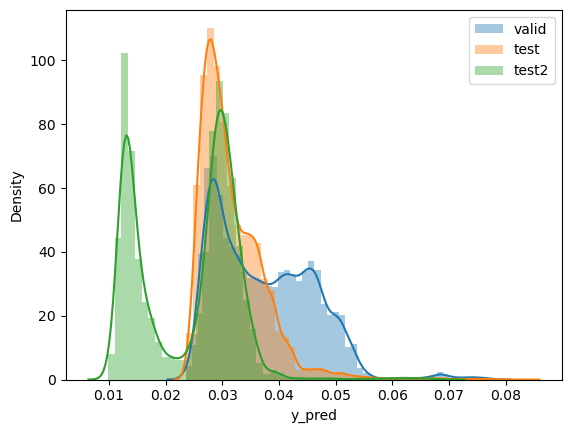

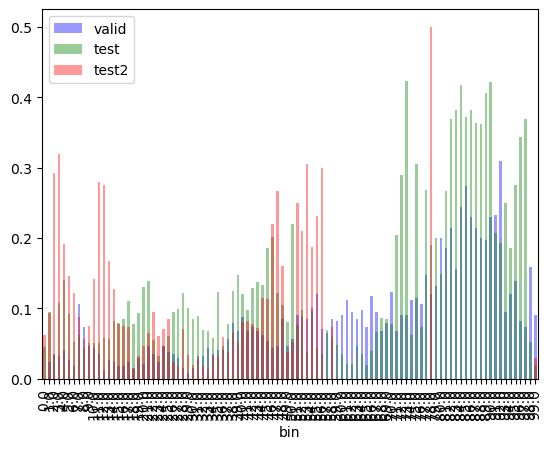

NVTK
[0.0589 0.0906]


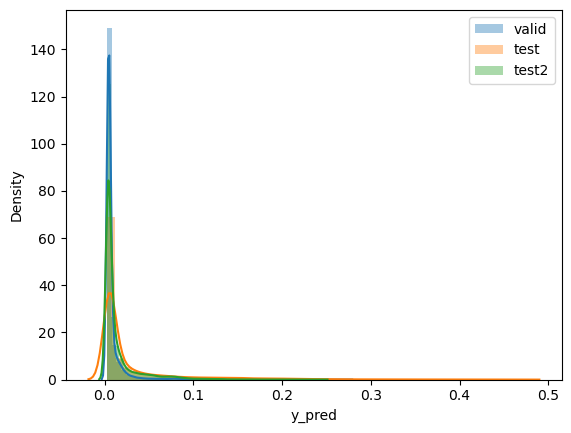

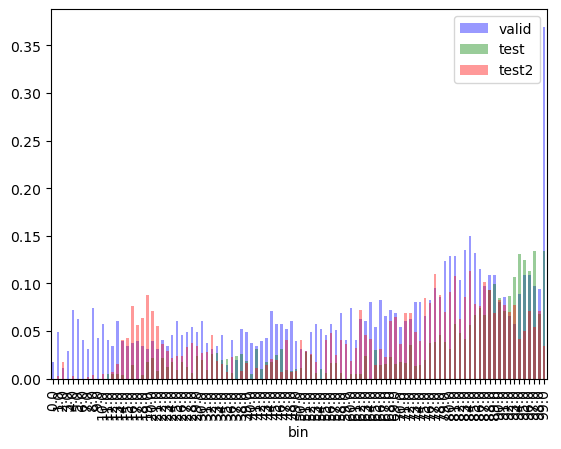

SNGS
[0.2655 0.2716]


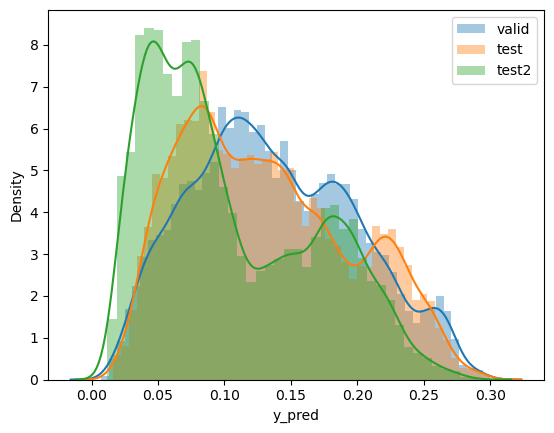

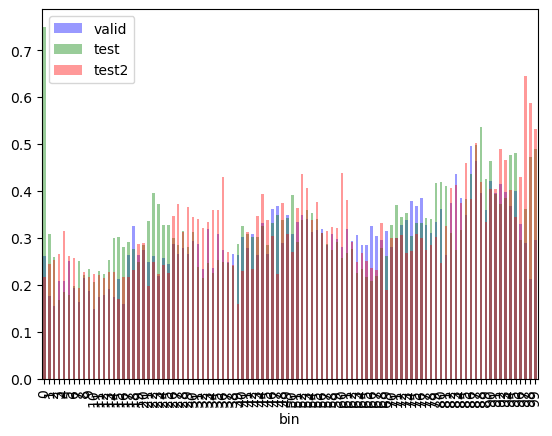

GMKN
[0.2083 0.2272]


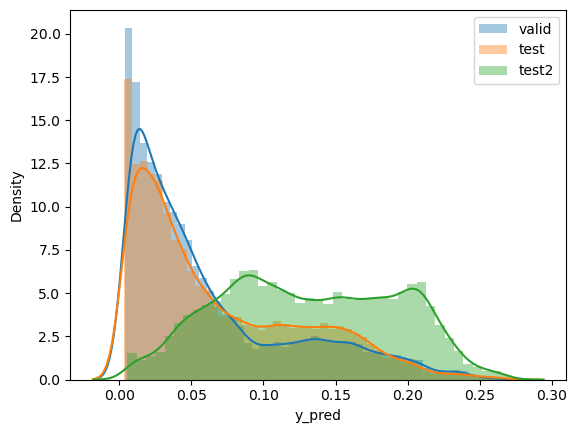

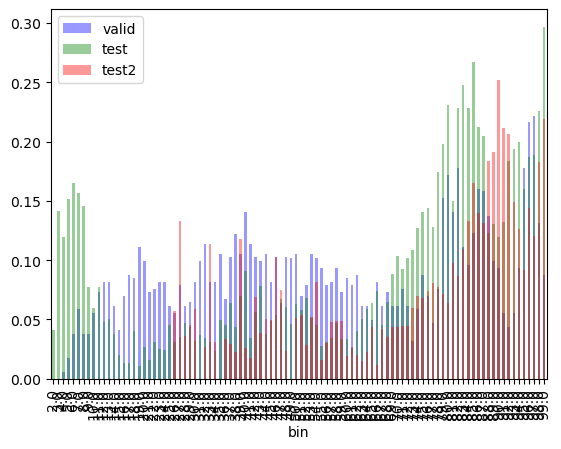

ROSN
[0.0894 0.1224]


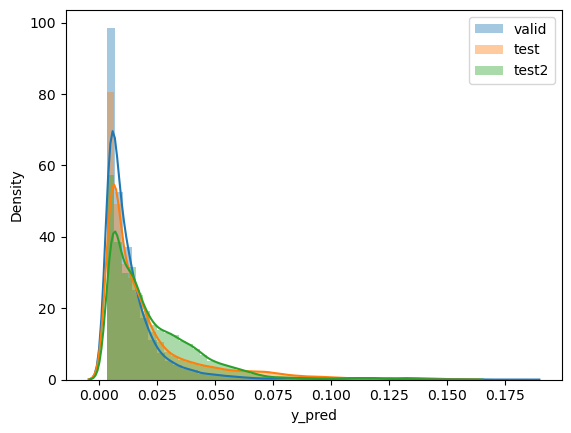

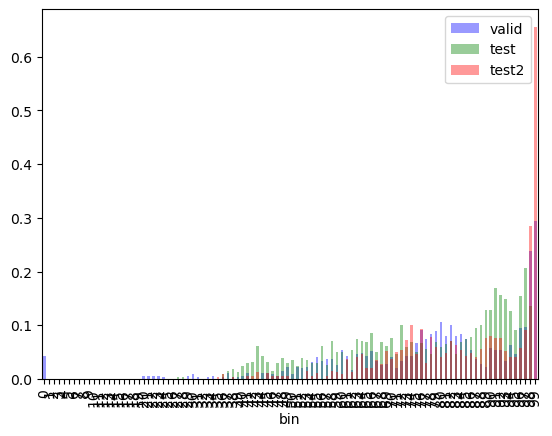

NLMK
[0.2061 0.2203]


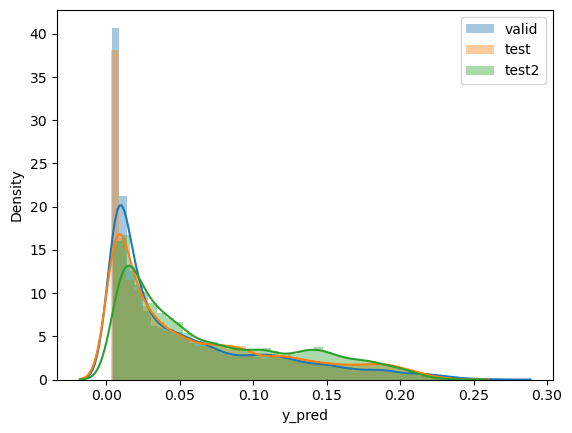

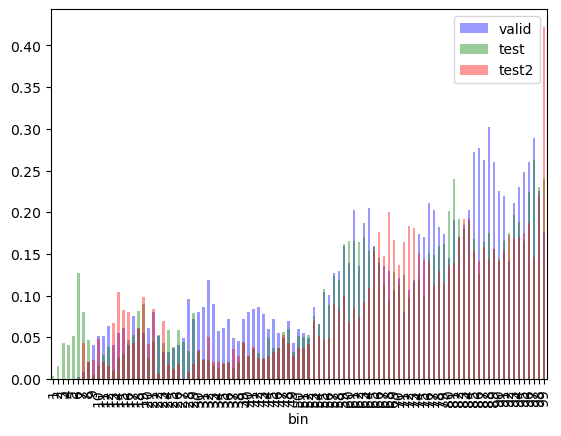

TATN
[0.1332 0.1522]


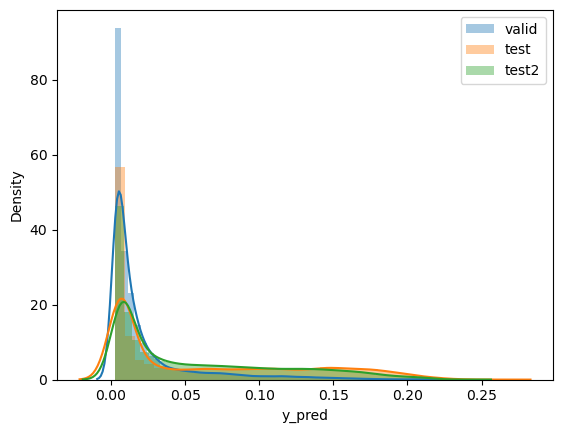

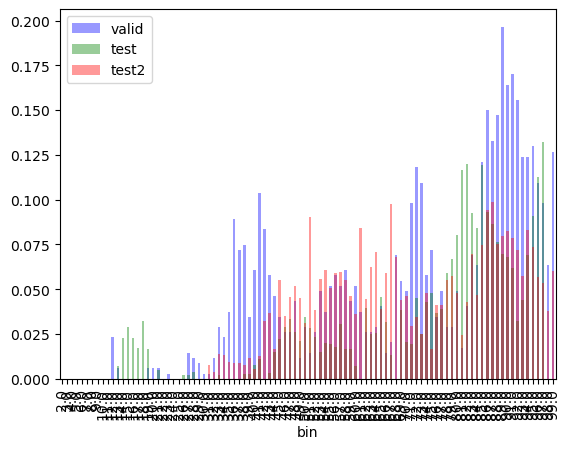

MTSS
[0.2605 0.2826]


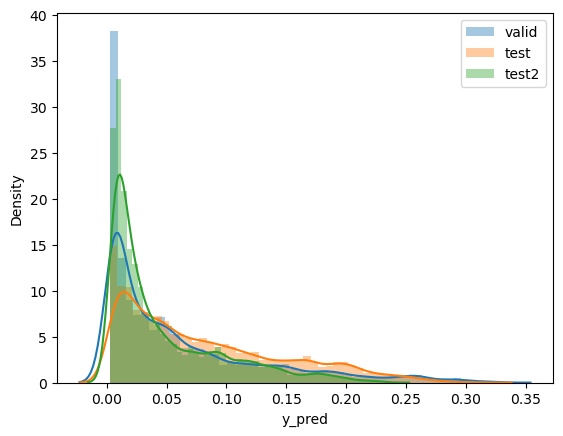

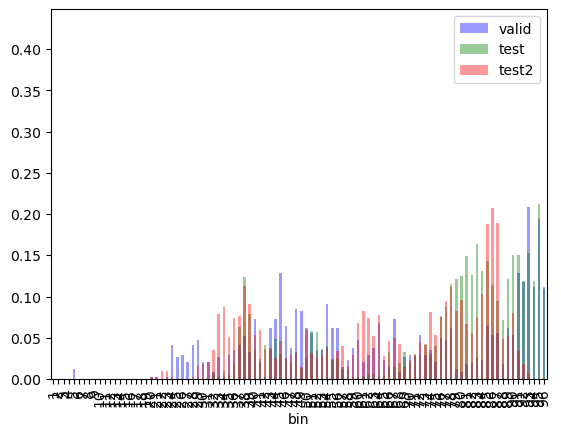

ALRS
[0.2669 0.2703]


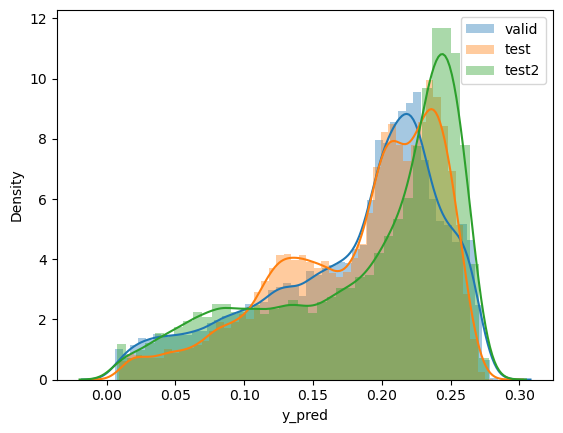

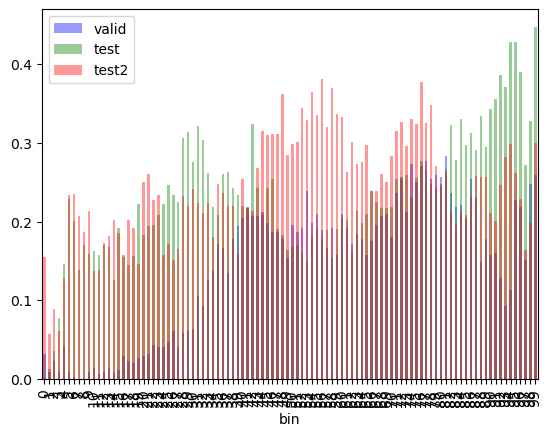

YDEX
[0.1704 0.1891]


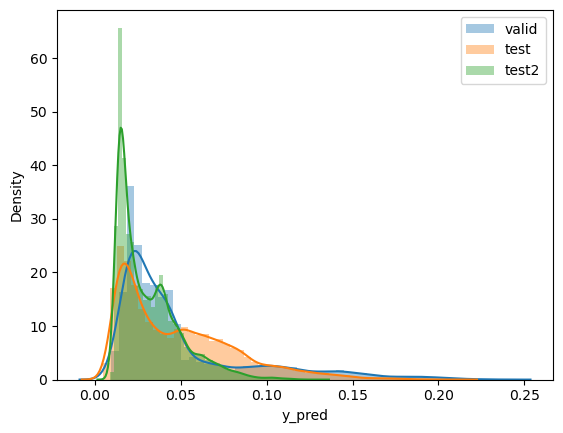

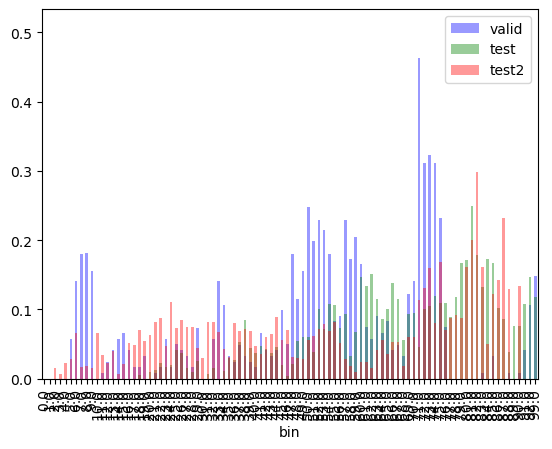

CHMF
[0.0737 0.0804]


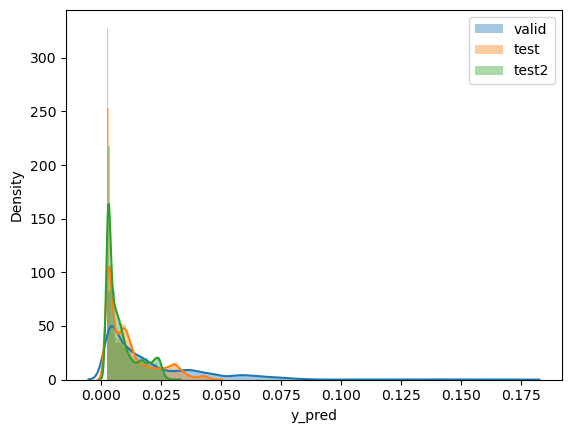

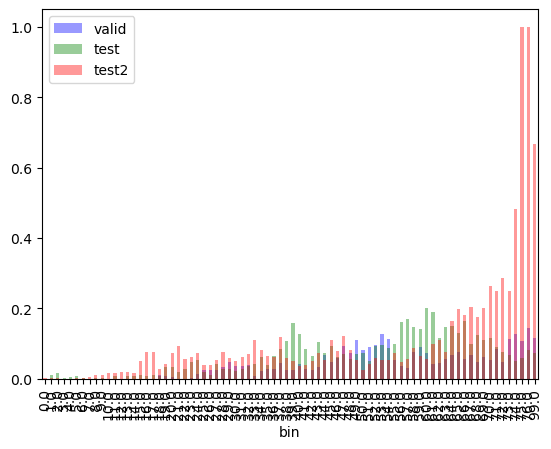

MAGN
[0.2452 0.2515]


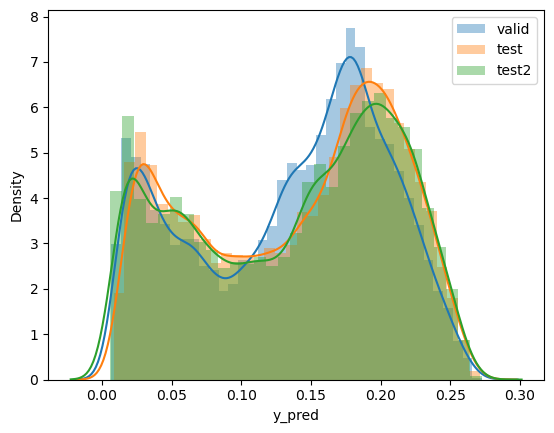

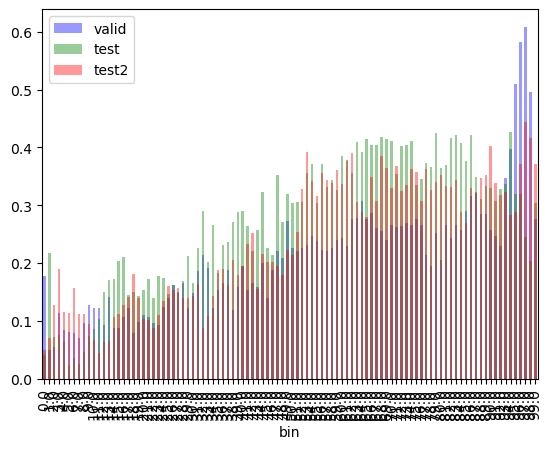

TCSG
[0.0561 0.0599]


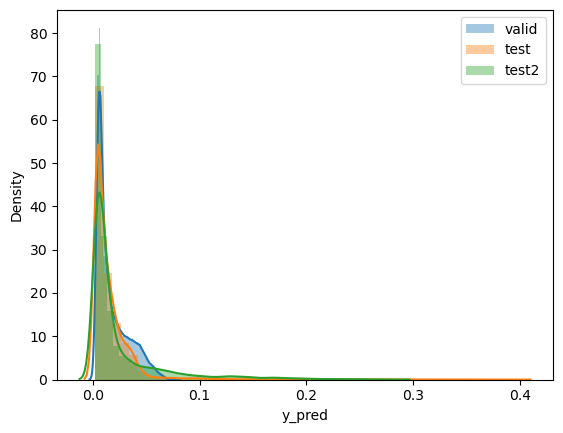

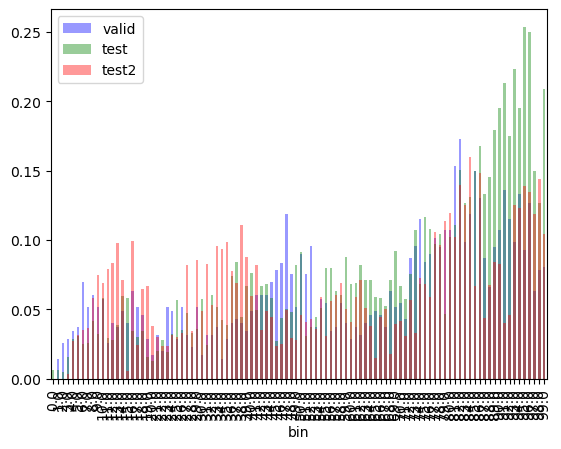

OZON
[0.137  0.1461]


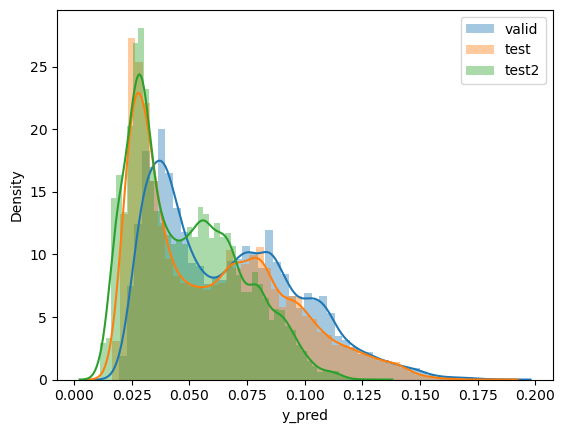

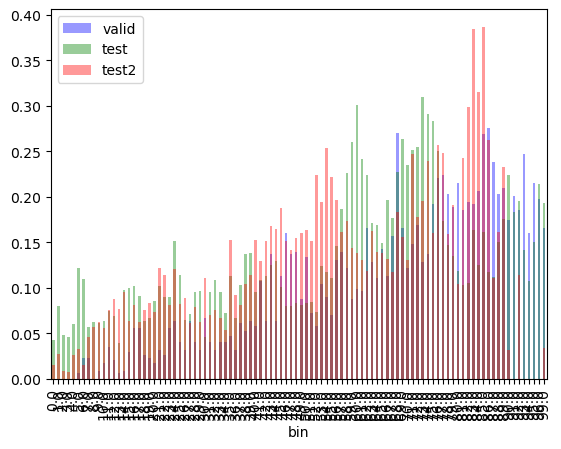

RUAL
[0.3756 0.3935]


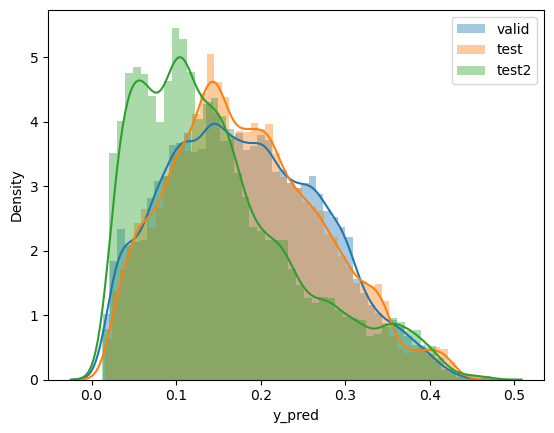

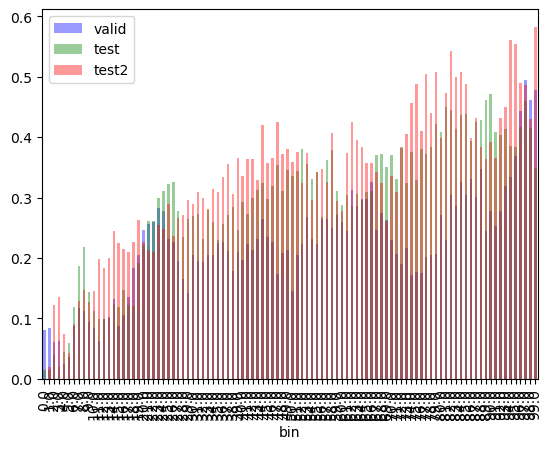

In [110]:
distplot(df, col_target='target',q_count=100)

In [ ]:
#Есть предрасположенные акции и наоборот

In [ ]:
#MAGN?,ALRS?, RUAL, SGNS

### таргет24

In [ ]:
[0.2582 0.2793]

In [359]:
#distplot(df, col_target='target24',q_count=50)

In [ ]:
#Похоже, что искать свой попрог в каждой акции не лучшая идея

### Рассмотрим общий порог для всех акций

In [124]:
def distplot_common_threshold(df, col_target=None, q_count=None):

    mask_valid = df['sample'] == 'valid'
    q = pd.qcut(df.loc[mask_valid, 'y_pred'], q_count, retbins=True)[1]
    
    for ticker in df['ticker'].unique():
        
        print(ticker)
        mask_valid = df['sample'] == 'valid'
        print(np.round(np.quantile(df.loc[mask_valid, 'y_pred'], q=[0.98, 0.99]).astype(float), decimals=4))
        
        df_tk = df.loc[df['ticker'] == ticker].copy()

        mask_valid = df_tk['sample'] == 'valid'
        mask_test = df_tk['sample'] == 'test'
        mask_test2 = df_tk['sample'] == 'test2'
        
        sns.distplot(df_tk.loc[mask_valid, 'y_pred'], label='valid')
        sns.distplot(df_tk.loc[mask_test, 'y_pred'], label='test')
        sns.distplot(df_tk.loc[mask_test2, 'y_pred'], label='test2')
        plt.legend()
        plt.show()



        
        df_tk['bin'] = None
        
        df_tk.loc[mask_valid, 'bin'] = pd.cut(df_tk.loc[mask_valid, 'y_pred'], bins=q, labels=False, include_lowest=True)
        df_tk.loc[mask_valid, 'bin'] = df_tk.loc[mask_valid, 'bin'].fillna(q_count-1)
        df_tk.loc[mask_valid, ['bin', col_target]].groupby('bin')[col_target].mean().plot.bar(sharex=True, label='valid', color='blue', alpha=0.4)
        
        
        df_tk.loc[mask_test, 'bin'] = pd.cut(df_tk.loc[mask_test, 'y_pred'], bins=q, labels=False, include_lowest=True)
        df_tk.loc[mask_test, 'bin'] = df_tk.loc[mask_test, 'bin'].fillna(q_count-1)
        df_tk.loc[mask_test, ['bin', col_target]].groupby('bin')[col_target].mean().plot.bar(sharex=True, label='test', color='green', alpha=0.4)
        
        
        df_tk.loc[mask_test2, 'bin'] = pd.cut(df_tk.loc[mask_test2, 'y_pred'], bins=q, labels=False, include_lowest=True)
        df_tk.loc[mask_test2, 'bin'] = df_tk.loc[mask_test2, 'bin'].fillna(q_count-1)
        df_tk.loc[mask_test2, ['bin', col_target]].groupby('bin')[col_target].mean().plot.bar(sharex=True,label='test2', color='red', alpha=0.4)

        mask_last_bin = df_tk['bin'] == q_count-1
        plt.legend()
        plt.show()
        print(f'PRECISION: {round(df_tk.loc[mask_valid&mask_last_bin, col_target].mean(), 2)}, {round(df_tk.loc[mask_test&mask_last_bin, col_target].mean(), 2)}, {round(df_tk.loc[mask_test2&mask_last_bin, col_target].mean(), 2)}')
        
        

### общий порог, таргет4

GAZP
[0.2582 0.2793]


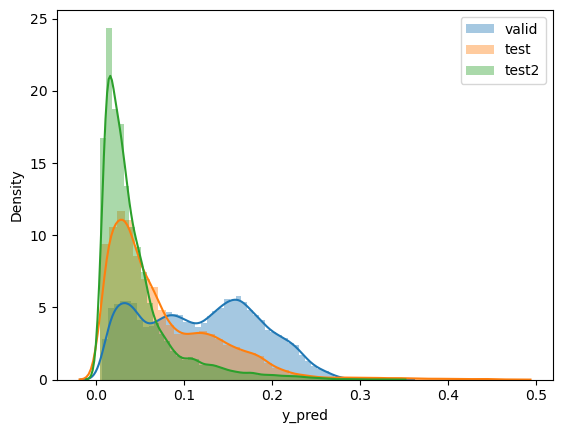

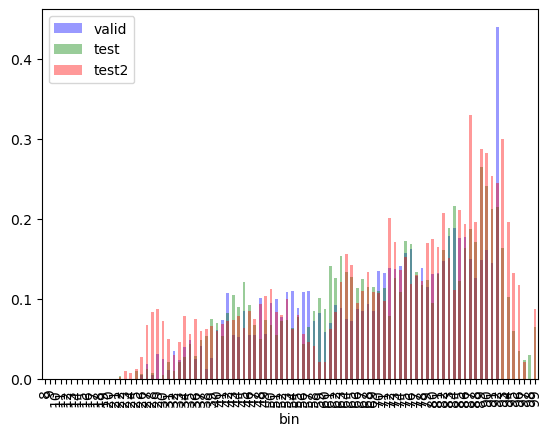

PRECISION: 0.44, 0.07, 0.09
SBER
[0.2582 0.2793]


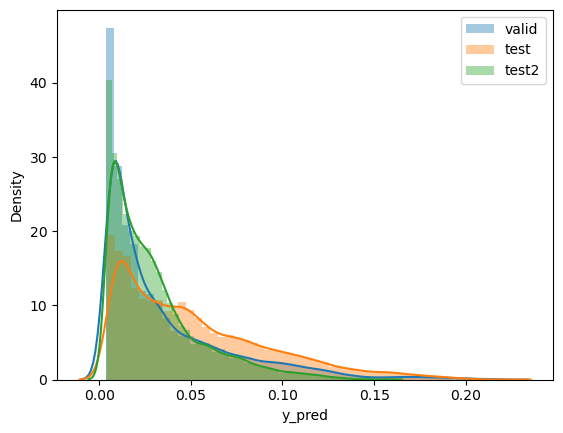

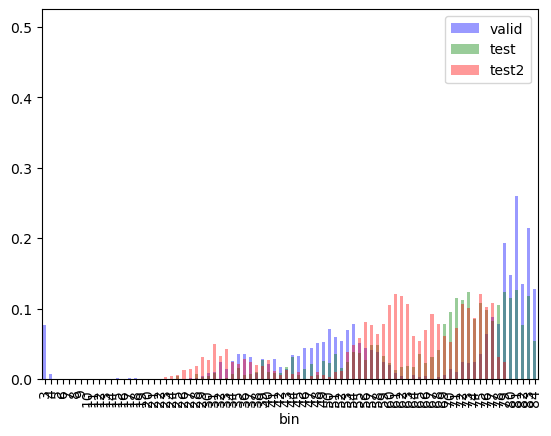

PRECISION: nan, nan, nan
LKOH
[0.2582 0.2793]


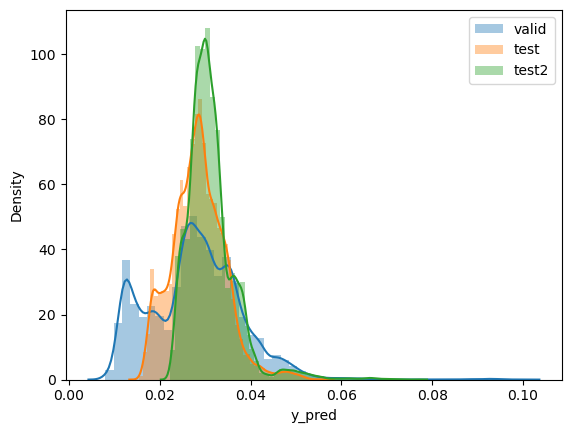

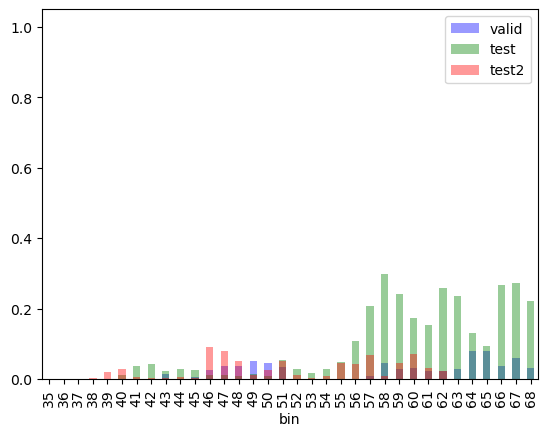

PRECISION: nan, nan, nan
MGNT
[0.2582 0.2793]


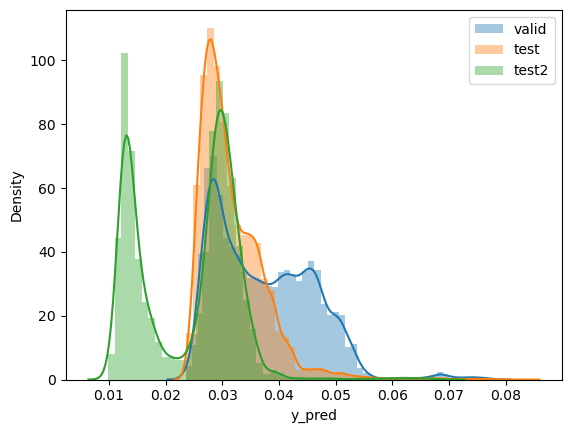

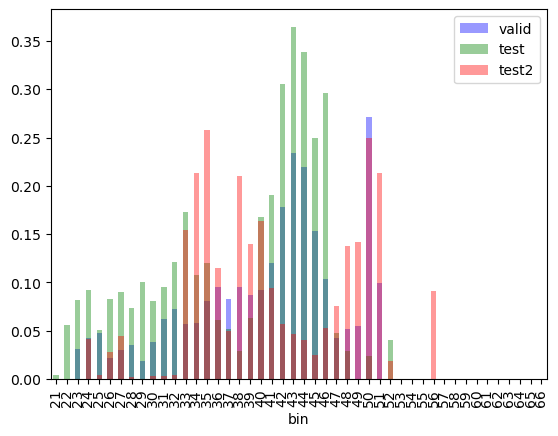

PRECISION: nan, nan, nan
NVTK
[0.2582 0.2793]


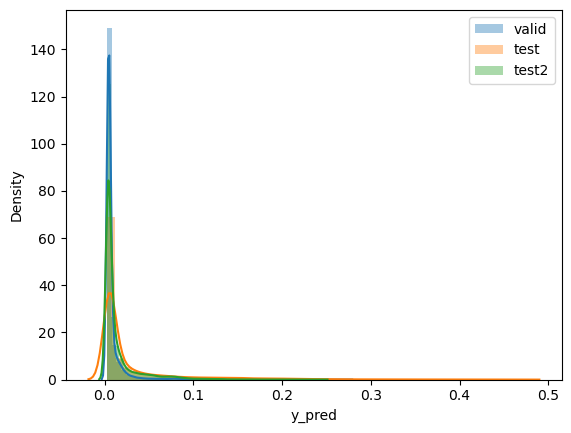

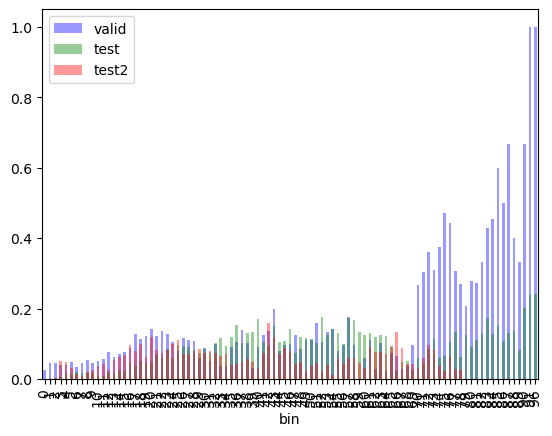

PRECISION: nan, 0.01, nan
SNGS
[0.2582 0.2793]


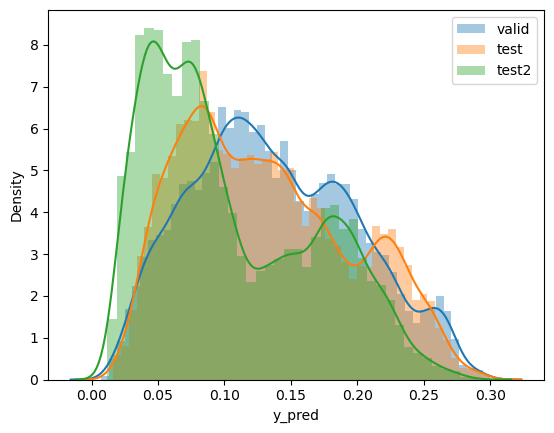

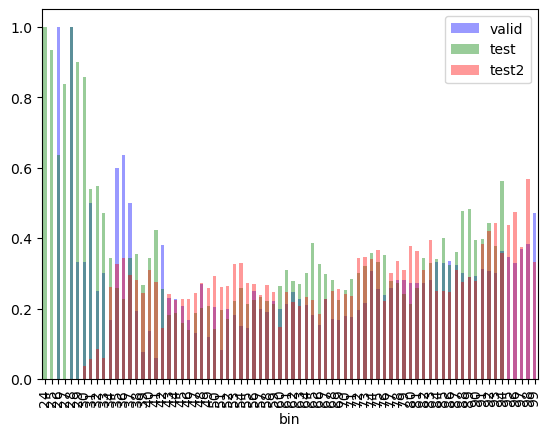

PRECISION: 0.39, 0.56, 0.33
GMKN
[0.2582 0.2793]


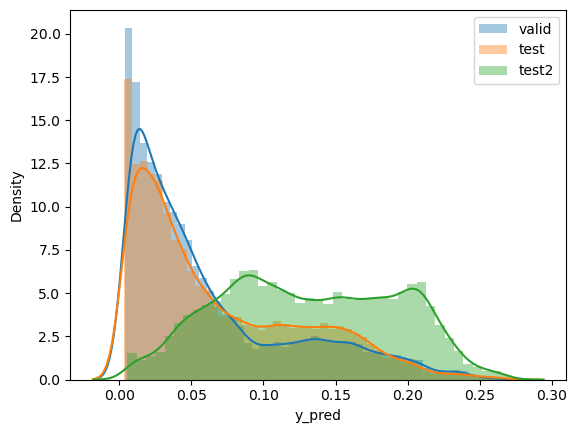

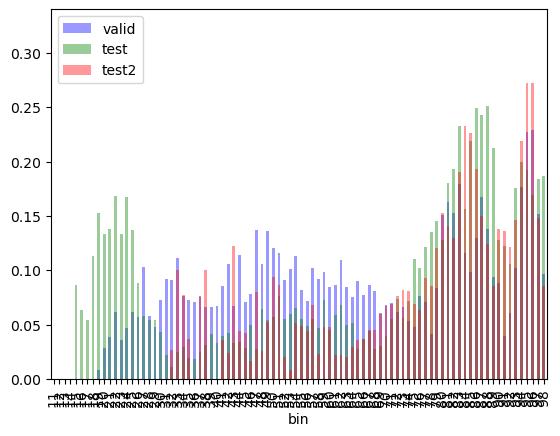

PRECISION: nan, nan, nan
ROSN
[0.2582 0.2793]


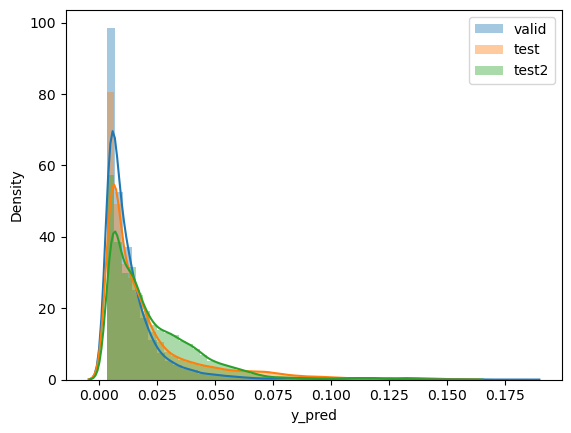

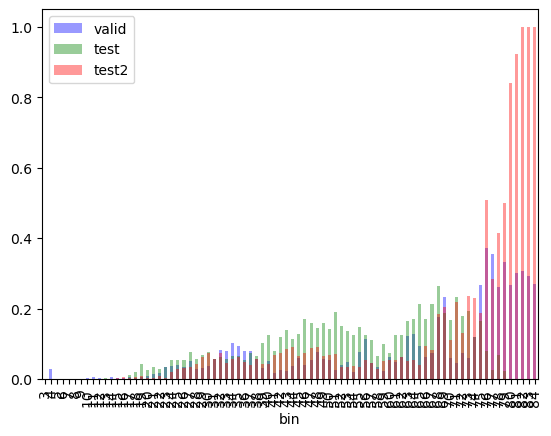

PRECISION: nan, nan, nan
NLMK
[0.2582 0.2793]


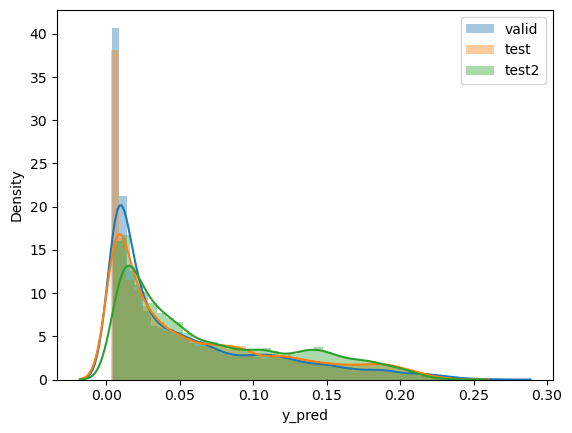

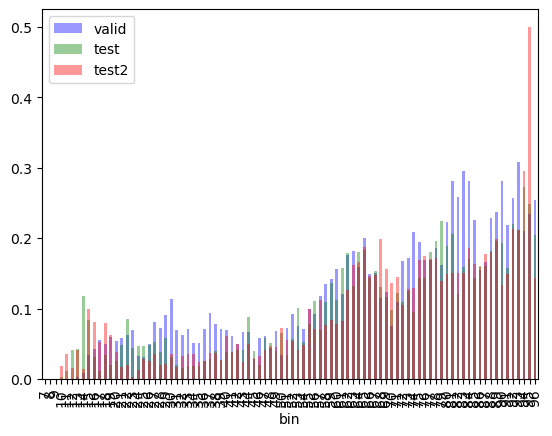

PRECISION: nan, nan, nan
TATN
[0.2582 0.2793]


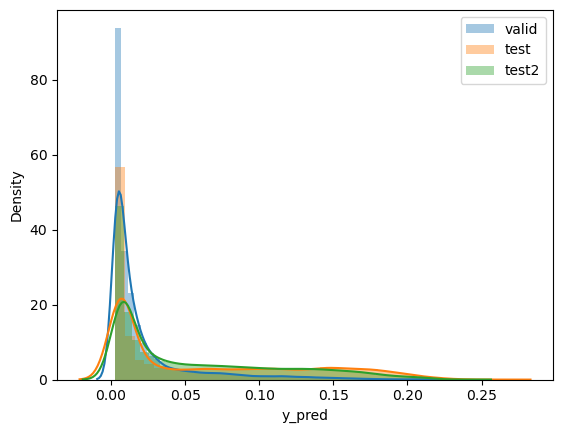

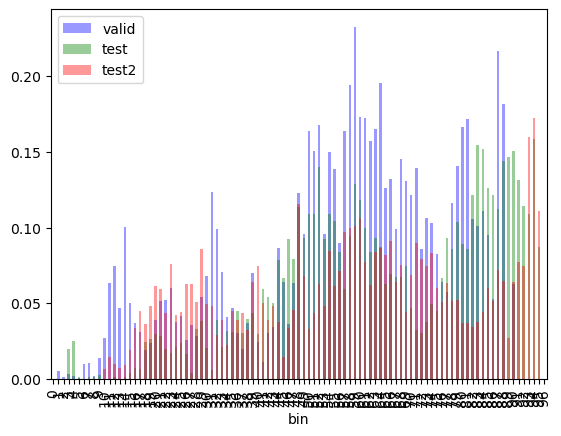

PRECISION: nan, nan, nan
MTSS
[0.2582 0.2793]


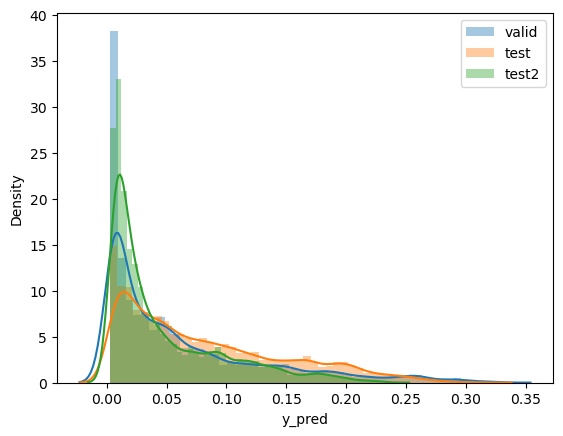

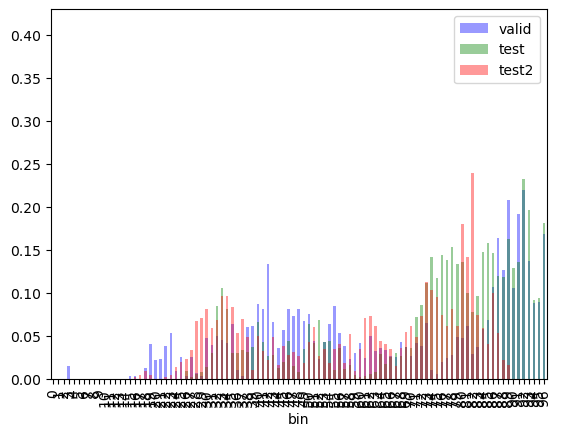

PRECISION: 0.02, 0.1, nan
ALRS
[0.2582 0.2793]


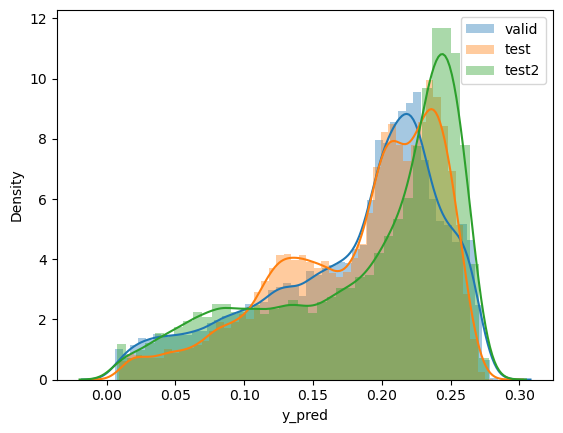

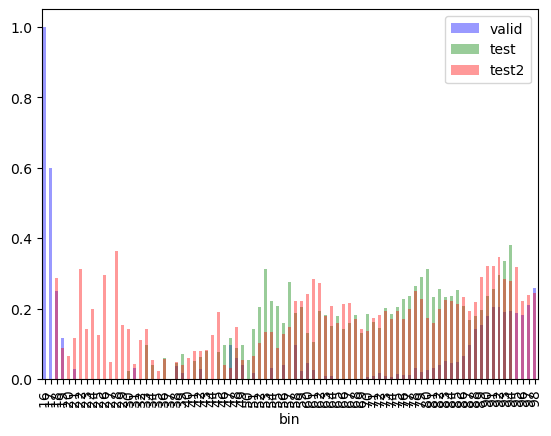

PRECISION: 0.0, 0.0, nan
YDEX
[0.2582 0.2793]


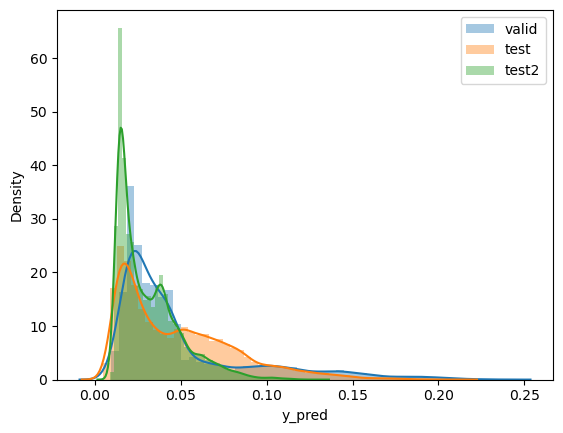

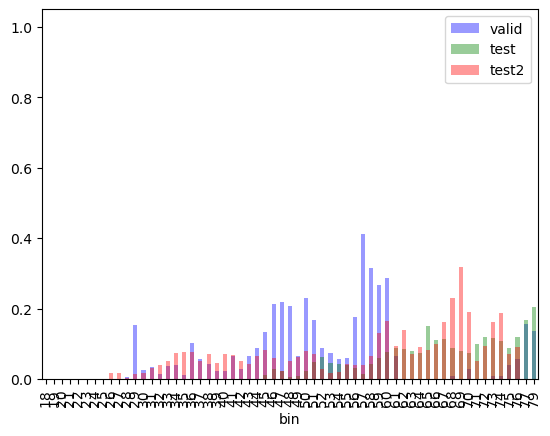

PRECISION: nan, nan, nan
CHMF
[0.2582 0.2793]


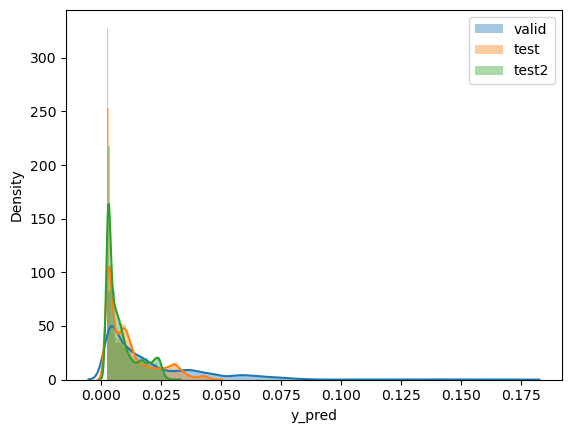

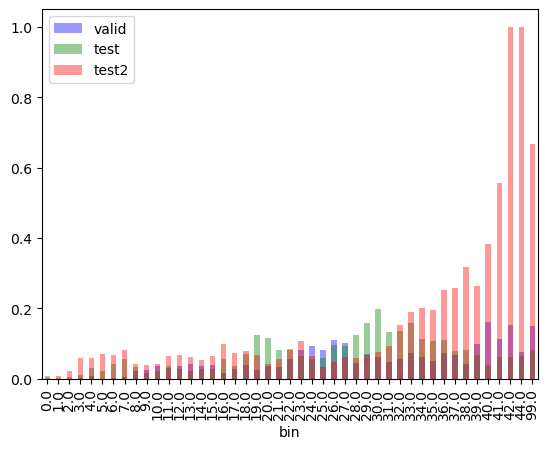

PRECISION: nan, 0.0, 0.67
MAGN
[0.2582 0.2793]


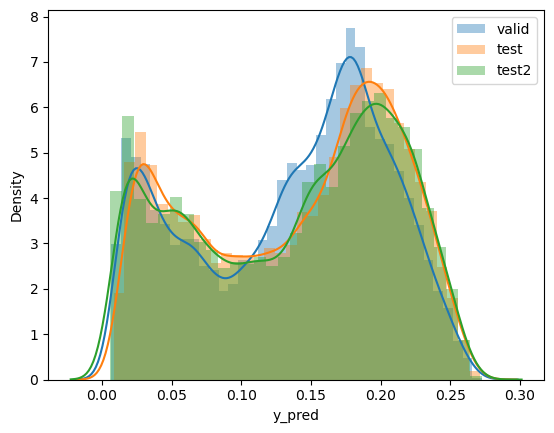

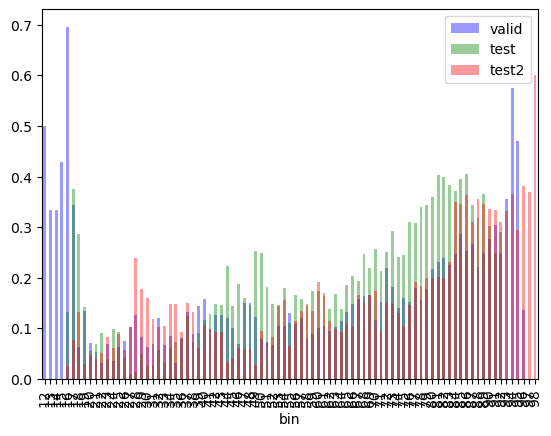

PRECISION: nan, nan, nan
TCSG
[0.2582 0.2793]


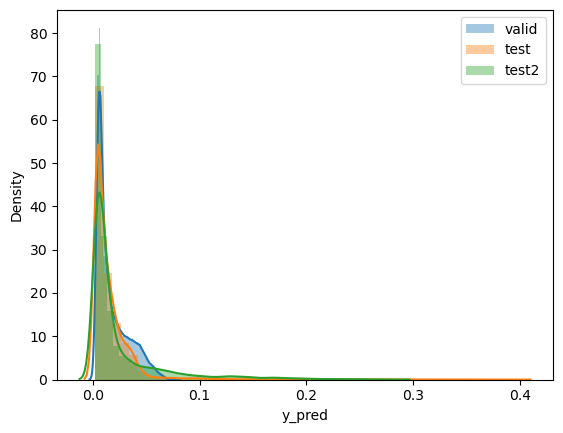

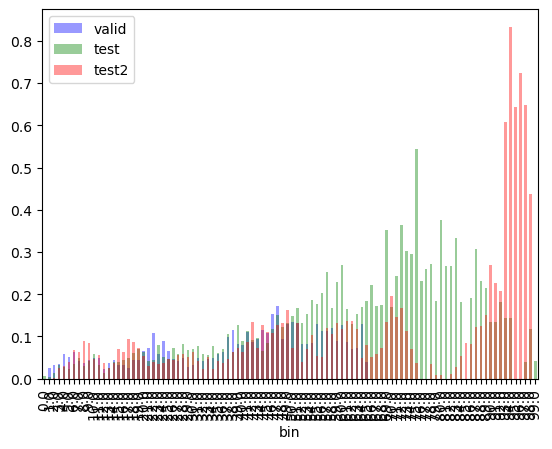

PRECISION: nan, 0.04, 0.0
OZON
[0.2582 0.2793]


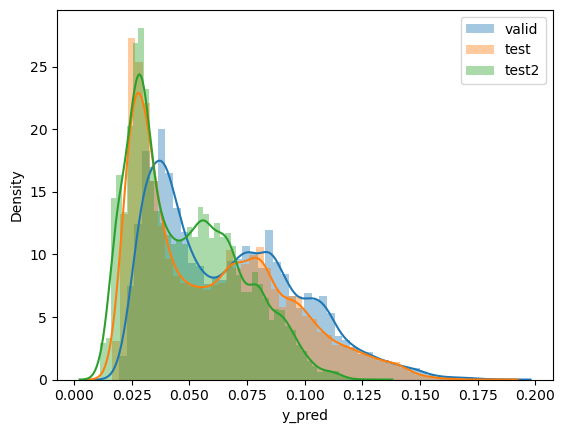

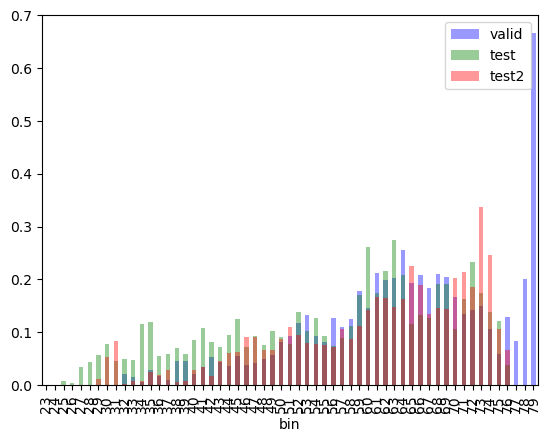

PRECISION: nan, nan, nan
RUAL
[0.2582 0.2793]


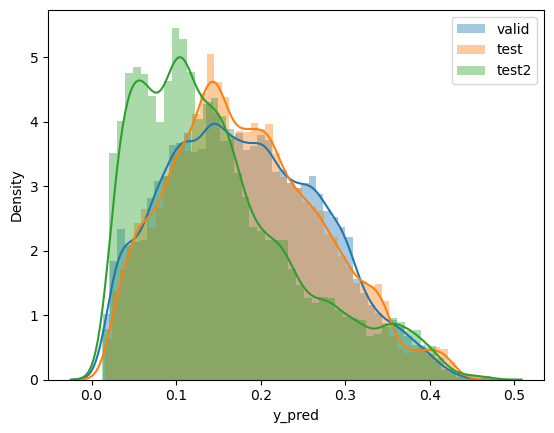

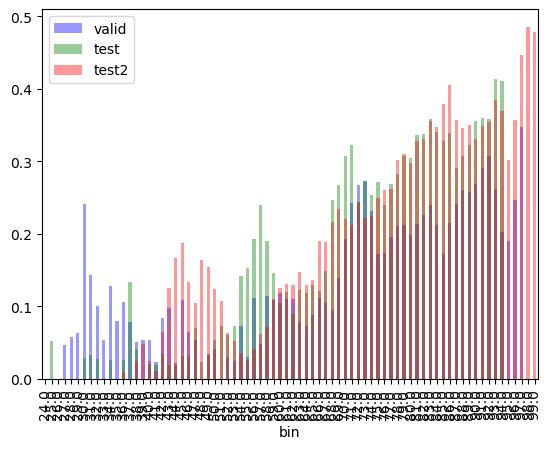

PRECISION: 0.35, 0.41, 0.48


In [128]:
distplot_common_threshold(df, col_target='target',q_count=100)

In [ ]:
# Идем в RUAL

### общий порог, таргет12

In [408]:
# distplot_common_threshold(df, col_target='target24',q_count=50)

In [ ]:
#тут результаты плохие в разрезе акций

# Донастройка

In [ ]:
# По сути интересен только 99(98)-перцентиль

In [133]:
threshold = np.quantile(df.loc[mask_valid, 'y_pred'], q=0.99)
print(f'threshokd = {threshold}')

mask = df['y_pred'] > threshold
print(df.loc[mask_valid&mask, 'target'].mean())

#threshold = np.quantile(df.loc[mask_test, 'y_pred'], q=0.99)
#mask = df['y_pred'] > threshold
print(df.loc[mask_test&mask, 'target'].mean())

#threshold = np.quantile(df.loc[mask_test2, 'y_pred'], q=0.99)
#mask = df['y_pred'] > threshold
print(df.loc[mask_test2&mask, 'target'].mean())

threshokd = 0.27928870558738716
0.3289253431536659
0.3600185099490976
0.4749132218365415


[0.2582 0.2793]


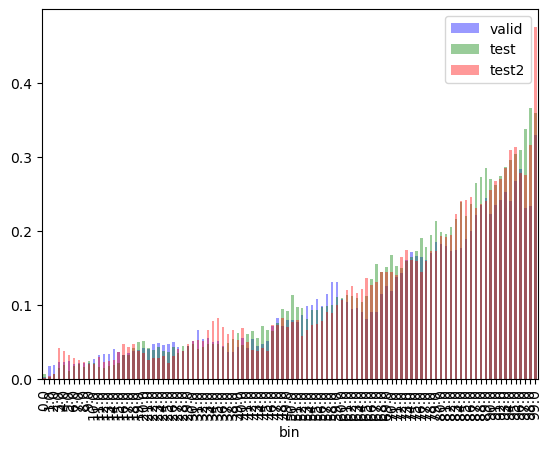

In [139]:
col_target = 'target'
q_count = 100

print(np.round(np.quantile(df.loc[mask_valid, 'y_pred'], q=[0.98, 0.99]).astype(float), decimals=4))

df['bin'] = None

df.loc[mask_valid, 'bin'] = pd.qcut(df.loc[mask_valid, 'y_pred'], q_count, labels=False)
q = pd.qcut(df.loc[mask_valid, 'y_pred'], q_count, retbins=True)[1]
df.loc[mask_valid, ['bin', col_target]].groupby('bin')[col_target].mean().plot.bar(sharex=True, label='valid', color='blue', alpha=0.4)


df.loc[mask_test, 'bin'] = pd.cut(df.loc[mask_test, 'y_pred'], bins=q, labels=False, include_lowest=True)
df.loc[mask_test, 'bin'] = df.loc[mask_test, 'bin'].fillna(q_count-1)
df.loc[mask_test, ['bin', col_target]].groupby('bin')[col_target].mean().plot.bar(sharex=True, label='test', color='green', alpha=0.4)


df.loc[mask_test2, 'bin'] = pd.cut(df.loc[mask_test2, 'y_pred'], bins=q, labels=False, include_lowest=True)
df.loc[mask_test2, 'bin'] = df.loc[mask_test2, 'bin'].fillna(q_count-1)
df.loc[mask_test2, ['bin', col_target]].groupby('bin')[col_target].mean().plot.bar(sharex=True,label='test2', color='red', alpha=0.4)

plt.legend()
plt.show()

In [ ]:
Нужно сделать экспотенциальное сглаживание, а коэффициент подобрать исходя из пресижн на valid

In [156]:

# alpha = 0.3
# for ticker in df['ticker'].unique():
#     df_tk = df.loc[(df['ticker'] == ticker].copy()

#     y_new = np.array(df_tk['y_pred'].copy())
#     # for i in tqdm(range(y_new)):
#     #     pass
    



    
    
    

In [203]:
def exp_smoothing(df, col_target, alpha, q=0.99):
    mask = df['sample'].notnull()
    y_pred = np.array(df.loc[mask, 'y_pred']).copy()

    mask_valid = df['sample'] == 'valid'
    mask_test = df['sample'] == 'test'
    mask_test2 = df['sample'] == 'test2'
    
    for i in range(1, y_pred.shape[0]):
        y_pred[i] = (1-alpha)*y_pred[i-1] + alpha*y_pred[i]
    
    df['y_pred_exp'] = None
    df.loc[mask, 'y_pred_exp'] = y_pred


    
    threshold = np.quantile(df.loc[mask_valid, 'y_pred_exp'], q=q)
    mask_last_bin = df['y_pred_exp'] > threshold
    
    print(f'ALPHA = {round(alpha,3)}, PRECISION: {round(df.loc[mask_valid&mask_last_bin, col_target].mean(), 2)}, {round(df.loc[mask_test&mask_last_bin, col_target].mean(), 2)}, {round(df.loc[mask_test2&mask_last_bin, col_target].mean(), 2)}')
    

### таргет4

In [191]:
for alpha in np.arange(0.1, 1, 0.1):
    exp_smoothing(df, 'target', alpha, q=0.995)

ALPHA = 0.1, PRECISION: 0.38, 0.35, 0.5
ALPHA = 0.2, PRECISION: 0.38, 0.34, 0.5
ALPHA = 0.3, PRECISION: 0.38, 0.34, 0.51
ALPHA = 0.4, PRECISION: 0.37, 0.34, 0.51
ALPHA = 0.5, PRECISION: 0.38, 0.34, 0.51
ALPHA = 0.6, PRECISION: 0.38, 0.34, 0.5
ALPHA = 0.7, PRECISION: 0.38, 0.34, 0.5
ALPHA = 0.8, PRECISION: 0.38, 0.34, 0.5
ALPHA = 0.9, PRECISION: 0.38, 0.34, 0.5


In [199]:
for alpha in np.arange(0.01, 0.11, 0.01):
    exp_smoothing(df, 'target', alpha, q=0.995)

ALPHA = 0.01, PRECISION: 0.4, 0.41, 0.56
ALPHA = 0.02, PRECISION: 0.4, 0.36, 0.49
ALPHA = 0.03, PRECISION: 0.4, 0.35, 0.48
ALPHA = 0.04, PRECISION: 0.39, 0.35, 0.48
ALPHA = 0.05, PRECISION: 0.39, 0.35, 0.49
ALPHA = 0.06, PRECISION: 0.38, 0.35, 0.5
ALPHA = 0.07, PRECISION: 0.38, 0.35, 0.5
ALPHA = 0.08, PRECISION: 0.39, 0.35, 0.5
ALPHA = 0.09, PRECISION: 0.38, 0.35, 0.5
ALPHA = 0.1, PRECISION: 0.38, 0.35, 0.5


In [207]:
for alpha in np.arange(0.005, 0.05, 0.005):
    exp_smoothing(df, 'target', alpha, q=0.995)

ALPHA = 0.005, PRECISION: 0.43, 0.42, 0.56
ALPHA = 0.01, PRECISION: 0.4, 0.41, 0.56
ALPHA = 0.015, PRECISION: 0.41, 0.38, 0.52
ALPHA = 0.02, PRECISION: 0.4, 0.36, 0.49
ALPHA = 0.025, PRECISION: 0.4, 0.35, 0.48
ALPHA = 0.03, PRECISION: 0.4, 0.35, 0.48
ALPHA = 0.035, PRECISION: 0.39, 0.35, 0.48
ALPHA = 0.04, PRECISION: 0.39, 0.35, 0.48
ALPHA = 0.045, PRECISION: 0.39, 0.35, 0.49


In [209]:
for alpha in np.arange(0.001, 0.011, 0.001):
    exp_smoothing(df, 'target', alpha, q=0.995)

ALPHA = 0.001, PRECISION: 0.32, 0.31, 0.4
ALPHA = 0.002, PRECISION: 0.35, 0.33, 0.56
ALPHA = 0.003, PRECISION: 0.38, 0.38, 0.56
ALPHA = 0.004, PRECISION: 0.43, 0.41, 0.57
ALPHA = 0.005, PRECISION: 0.43, 0.42, 0.56
ALPHA = 0.006, PRECISION: 0.42, 0.42, 0.58
ALPHA = 0.007, PRECISION: 0.41, 0.41, 0.6
ALPHA = 0.008, PRECISION: 0.4, 0.41, 0.59
ALPHA = 0.009, PRECISION: 0.39, 0.41, 0.58
ALPHA = 0.01, PRECISION: 0.4, 0.41, 0.56


In [ ]:
#ALPHA = 0.005, PRECISION: 0.43, 0.42, 0.56

### таргет 24

In [221]:
for alpha in np.arange(0.1, 1.1, 0.1):
    exp_smoothing(df, 'target24', alpha, q=0.995)

ALPHA = 0.1, PRECISION: 0.48, 0.4, 0.5
ALPHA = 0.2, PRECISION: 0.48, 0.39, 0.51
ALPHA = 0.3, PRECISION: 0.48, 0.39, 0.51
ALPHA = 0.4, PRECISION: 0.47, 0.39, 0.51
ALPHA = 0.5, PRECISION: 0.47, 0.39, 0.51
ALPHA = 0.6, PRECISION: 0.47, 0.39, 0.51
ALPHA = 0.7, PRECISION: 0.47, 0.39, 0.51
ALPHA = 0.8, PRECISION: 0.47, 0.39, 0.51
ALPHA = 0.9, PRECISION: 0.47, 0.39, 0.51
ALPHA = 1.0, PRECISION: 0.47, 0.39, 0.51


In [225]:
for alpha in np.arange(0.01, 0.11, 0.01):
    exp_smoothing(df, 'target24', alpha, q=0.995)

ALPHA = 0.01, PRECISION: 0.47, 0.51, 0.57
ALPHA = 0.02, PRECISION: 0.47, 0.43, 0.49
ALPHA = 0.03, PRECISION: 0.47, 0.41, 0.48
ALPHA = 0.04, PRECISION: 0.47, 0.41, 0.49
ALPHA = 0.05, PRECISION: 0.47, 0.41, 0.5
ALPHA = 0.06, PRECISION: 0.47, 0.4, 0.5
ALPHA = 0.07, PRECISION: 0.47, 0.4, 0.5
ALPHA = 0.08, PRECISION: 0.48, 0.4, 0.5
ALPHA = 0.09, PRECISION: 0.48, 0.4, 0.5
ALPHA = 0.1, PRECISION: 0.48, 0.4, 0.5


In [229]:
for alpha in np.arange(0.001, 0.011, 0.001):
    exp_smoothing(df, 'target24', alpha, q=0.995)

ALPHA = 0.001, PRECISION: 0.48, 0.54, 0.6
ALPHA = 0.002, PRECISION: 0.49, 0.47, 0.66
ALPHA = 0.003, PRECISION: 0.53, 0.53, 0.62
ALPHA = 0.004, PRECISION: 0.55, 0.54, 0.6
ALPHA = 0.005, PRECISION: 0.53, 0.55, 0.58
ALPHA = 0.006, PRECISION: 0.5, 0.54, 0.6
ALPHA = 0.007, PRECISION: 0.48, 0.53, 0.6
ALPHA = 0.008, PRECISION: 0.47, 0.52, 0.6
ALPHA = 0.009, PRECISION: 0.46, 0.52, 0.59
ALPHA = 0.01, PRECISION: 0.47, 0.51, 0.57


In [ ]:
#ALPHA = 0.005, PRECISION: 0.53, 0.55, 0.58

In [ ]:
#И сколько их в день интересно? И на каких акциях?

In [389]:
exp_smoothing(df, 'target24', 0.1, q=0.995)

ALPHA = 0.1, PRECISION: 0.48, 0.4, 0.5


In [391]:
mask_valid = df['sample'] == 'valid'
threshold = np.quantile(df.loc[mask_valid, 'y_pred_exp'], q=0.995)
threshold

0.3072430842799789

In [393]:
mask_threshold = df['y_pred_exp']  > threshold

In [402]:
mask_test = df['sample'] == 'test'
mask_test2 = df['sample'] == 'test2'

df.loc[mask_valid&mask_threshold].shape[0], df.loc[mask_test&mask_threshold].shape[0], df.loc[mask_test2&mask_threshold].shape[0]

(2987, 3894, 2274)

In [406]:
df.loc[mask_valid&mask_threshold, 'time'].dt.date.nunique(), df.loc[mask_test&mask_threshold, 'time'].dt.date.nunique(), df.loc[mask_test2&mask_threshold, 'time'].dt.date.nunique()

(17, 16, 10)

In [408]:
df.loc[mask_valid&mask_threshold, 'ticker'].unique(), df.loc[mask_test&mask_threshold, 'ticker'].unique(), df.loc[mask_test2&mask_threshold, 'ticker'].unique()

(array(['GAZP', 'MTSS', 'RUAL'], dtype=object),
 array(['GAZP', 'NVTK', 'TCSG', 'RUAL'], dtype=object),
 array(['RUAL'], dtype=object))